In [95]:
from time import time
import numpy as np
from tst.domutil.util import *
from copy import copy
from scipy.sparse import *
from scipy.spatial.distance import *


def normalise(hc1, hc2, hcboth):
    log1 =  np.log10( hc1 + 1) 
    log2 =  np.log10( hc1 + 1) 
    log3 =  np.log10( hcboth + 1) 
    norm = (log1 + log2) / 2 - log3 
    return norm


def test__raw(D_raw, hmms):
    # next(counts.iteritems()[0]
    # it = counts.iteritems()
    it = using_tocoo_izip(D_raw)
    c = counter([],INF = 1)
    # for (x,y),v in it:
    for x,y,v in it:
#         print x,y
        hmm1 = hmms.get(id = x + 1)
        hmm2 = hmms.get(id = y + 1)
        hmm1hits = hmm1.hits.values_list('id')
        hmm2hits = hmm2.hits.values_list('id')
        interhits = set(hmm1hits) & set(hmm2hits)
        intercount = len(interhits)
#         print v
#         print intercount
        msg = '[OK] %s against %s overlaps %d, with %d from '%(hmm1,hmm2, intercount, v )
        print msg
        assert v == len(interhits),'[ERROR] %s against %s overlaps %d, while D_raw returns %d '%(hmm1,hmm2, intercount, v )
        c.count()
        if c.i == 5:
            break
            
def test__norm(D_curr, hmms):
    # next(counts.iteritems()[0]
    # it = counts.iteritems()
    it = using_tocoo_izip(D_curr)
    c = counter([],INF = 1)
    # for (x,y),v in it:
    for x,y,v_act in it:
#         print x,y
        hmm1 = hmms.get(id = x + 1)
        hmm2 = hmms.get(id = y + 1)
        hmm1hits = hmm1.hits.values_list('id')
        hmm2hits = hmm2.hits.values_list('id')
        interhits = set(hmm1hits) & set(hmm2hits)
        intercount = len(interhits)
        
        v_exp = normalise( len(hmm1hits), len(hmm2hits), intercount)
#         print v
#         print intercount
        msg = '[OK] %s against %s overlaps:: Expected:%s, Actual:%s'%(hmm1,hmm2, v_exp, v_act )
        print msg
        assert v_exp == v_act,'[ERROR] %s against %s overlaps:: Expected %s, Actual: %s '%(hmm1,hmm2, v_exp, v_act )
        c.count()
        if c.i == 5:
            break

from itertools import izip
def sort_coo(m,order = 1):
    tuples = izip(m.row, m.col, m.data)
    return sorted(tuples, key=lambda x: order * (x[2]) )

notlist = lambda lst: [not x for x in lst]

def reset_database_connection():
    from django import db
    db.close_old_connections()
# reset_database_connection()


In [2]:
%%time
# print "finished"
# ;
hmms = HMMprofile.objects.defer('text').all().prefetch_related('hits')
hmms = hmms.annotate(hcount = Count('hits')).order_by('id')

hmmids = list(hmms.values_list('id',flat = True))
hcounts = list(hmms.values_list('hcount',flat = True))
sfs = list(hmms.values_list('cath_node__parent',flat = True))

sDB = seqDB.objects.get(name = 'CATH')
sDB.sequence_set.count()
seq = sDB.sequence_set.first()

seqset_all = sDB.sequence_set.all().prefetch_related('hmmprofile_set')

# seq.HMMprofile
# seq.hmmprofile
# dir(seq)
seq.hmmprofile_set.count()


CPU times: user 92 ms, sys: 4 ms, total: 96 ms
Wall time: 41.9 s


In [ ]:
%%time

# hmms2hit_ids = lambda hmms: np.expand_dims(
#     np.array(
#     [list(
#         hmm.hits.values_list("id", flat = True)
#     )
#      for hmm in hmms]
# ), axis = 1)

# hmms2hit_ids_para = lambda hmms,pool: np.expand_dims(
#     np.array(
#     [list(
#         hmm.hits.values_list("id", flat = True)
#     )
#      for hmm in hmms]
# ), axis = 1)
X0 = hmms2hit_ids(hmms)

In [8]:
%%time

# t0 = time()
# c = counter(range(len(X)**2/2),per = 1E3)
# from multiprocessing import *

hmms_test = HMMprofile.objects.defer('text').all().prefetch_related('hits')[:200]
# hmms_test = HMMprofile.objects.defer('text').all().prefetch_related('hits')[:500]
X = hmms2hit_ids( hmms_test )

CPU times: user 324 ms, sys: 12 ms, total: 336 ms
Wall time: 442 ms


0.185712814331
19900


In [ ]:
from tst.domutil.util import *
# its = D.iteritems()
its = using_tocoo_izip(D)

xs = []
ys = []
zs = []
sfbools = [];

c = counter(range(6563388),per = 100000)

for xi,yi,inter_ct in its:
    c.count()
#     xct = 
    x = hcounts[xi]
    y = hcounts[yi]

    xs.append( x )
    ys.append( y )
    zs.append(inter_ct)
    sfbools.append(sfs[xi]==sfs[yi])
#     normz = log10()
# print next(its)
# print next(its)

# ys 

In [3]:
%%time

import itertools as it
from collections import Counter

def pair_gen(seqset_all):
    c = counter(range(seqset_all.count()))
    batches = batch_qs( seqset_all, 500)
    for seqset in batches:
        
#             hmmids = seq.values_list("hmmprofile",flat =True)
        for seq in seqset:
            c.count()
            hmmids = seq.hmmprofile_set.values_list("id",flat = True)
#             pairs = it.combinations(sorted(hmmids),2)
            pairs = it.combinations( hmmids ,2)
            for p in pairs:
                yield p

def batch_worker(seqset):
    count = Counter()
    for seq in seqset:
        c0.count()
        hmmids = seq.hmmprofile_set.values_list("id",flat = True)
    #             pairs = it.combinations(sorted(hmmids),2)
        pairs = it.combinations( hmmids ,2)
        count.update(pairs)
    q.put(count)
    c1.count()
    return 


def seq_counter(seq):
    c0.count()
    hmmids = seq.hmmprofile_set.values_list("id",flat = True)
#             pairs = it.combinations(sorted(hmmids),2)
    pairs = it.combinations( hmmids ,2)
    count = Counter(pairs)
    q.put(count)


    
    

def listener(counts):
#     counts = Counter([])
    i = 0
    while 1:
        print i
        i += 1
        c1.fail('Listener: %d '%(i))
        obj = q.get()
        if obj:
            counts.update(obj)
        else:
            q.put(counts)
            return
#     while 1:
#         pidx = q.get()
#         if pidx:
#             x,y = pidx 
#             D[x-1,y-1] += 1
#         else:
#             return D




CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 17.9 µs


In [4]:
print seqset_all.count()

80407


In [5]:
%%time
from scipy.sparse import *
import multiprocessing as mp
from multiprocessing.managers import BaseManager, SyncManager
# class MyManager(BaseManager): pass
class MyManager(SyncManager): pass
MyManager.register('counter',counter)


# c = counter(range(sDB.sequence_set.count()))

pcount = 5
# INPUT = seqset_all[:3000]
INPUT = seqset_all
ct1 = INPUT.count()
INPUT = batch_qs( INPUT, 600)

l = max(hmmids)
# OUTPUT = dok_matrix( (l,l), dtype = 'int')
OUTPUT = Counter()

local_worker = batch_worker
# local_worker = seq_counter
local_listener = listener      

if __name__=='__main__':
    
    #     m = mp.Manager()
        m = MyManager()
        m.start()
    #     raise Exception
    #     manager.start()
        c0 = m.counter( range(ct1),INF=0, ifprint = 1)
        c1 = m.counter( [],INF=1, ifprint = 1)

        q = m.Queue();          

        if 1:
            pool = mp.Pool( pcount )
            watcher  = mp.Process(target = local_listener, args = [OUTPUT])
            watcher.start()
#             watcher  = pool.apply_async(local_listener, args = [OUTPUT])
            jobs = []

            for INPUT_curr in INPUT:
                job  = pool.apply_async(local_worker, args = (INPUT_curr, ))
                jobs.append(job)
            for job in jobs:
                job.get()

#             jobs = pool.imap_unordered(local_listener, INPUT) 
#             for job in jobs:
#                 pass

#             jobs = [pool.map_async(local_listener, INPUT) ] 
#             r0 = job.get()
        
            q.put(None)
#             OUTPUT = watcher.get()
            watcher.join()
            OUTPUT = q.get() 
#             OUTPUT = 

0
Listener: 1 
0 of -1
100 of -1
200 of -1
300 of -1
400 of -1
500 of -1
600 of -1
700 of -1
800 of -1
 800 of -1
900 of -1
1000 of -1
1100 of -1
0 of -1
1200 of -1
1
Listener: 2 
1300 of -1
1400 of -1
Listener: 3 
2
1500 of -1
1600 of -1
1700 of -1
 1700 of -1
1800 of -1
1900 of -1
2000 of -1
2100 of -1
 2100 of -1
2200 of -1
 2200 of -1
2300 of -1
 2600 of -1
2400 of -1
2500 of -1
2600 of -1
2700 of -1
 2700 of -1
2800 of -1
3
Listener: 4 
2900 of -1
3000 of -1
3100 of -1
4
Listener: 5 
3200 of -1
3300 of -1
 3400 of -1
3400 of -1
3500 of -1
3600 of -1
5
Listener: 6 
3700 of -1
3800 of -1
3900 of -1
4000 of -1
4100 of -1
6
Listener: 7 
4200 of -1
 4200 of -1
4300 of -1
4400 of -1
4500 of -1
4600 of -1
 4600 of -1
4700 of -1
 4700 of -1
4800 of -1
4900 of -1
5000 of -1
5100 of -1
 5100 of -1
5200 of -1
5300 of -1
 5300 of -1
5400 of -1
5500 of -1
5600 of -1
 5600 of -1
 5700 of -1
5700 of -1
 5700 of -1
5800 of -1
 5800 of -1
 5900 of -1
 5900 of -1
5900 of -1
 6000 of -1
 6000 of -1


35000 of -1
 35000 of -1
 35000 of -1
 35000 of -1
35100 of -1
 35100 of -1
 35100 of -1
35200 of -1
Listener: 57 
 35200 of -1
56
35300 of -1
 35300 of -1
35400 of -1
 35400 of -1
 35400 of -1
35500 of -1
35600 of -1
35700 of -1
 35700 of -1
35800 of -1
 35800 of -1
35900 of -1
 35900 of -1
 35900 of -1
36000 of -1
 36000 of -1
36100 of -1
 36200 of -1
36200 of -1
57
Listener: 58 
36300 of -1
36400 of -1
58
Listener: 59 
36500 of -1
 36500 of -1
 36600 of -1
36600 of -1
 36600 of -1
36700 of -1
 36700 of -1
 36700 of -1
36800 of -1
 36900 of -1
36900 of -1
 37000 of -1
 37000 of -1
37000 of -1
 37000 of -1
59
Listener: 60 
37100 of -1
 37100 of -1
 37100 of -1
 37100 of -1
37200 of -1
 37300 of -1
 37300 of -1
37300 of -1
37400 of -1
60
Listener: 61 
37500 of -1
37600 of -1
 37600 of -1
 37600 of -1
37700 of -1
 37800 of -1
37800 of -1
 37900 of -1
37900 of -1
 38000 of -1
38000 of -1
 38100 of -1
38100 of -1
38200 of -1
 38200 of -1
 38200 of -1
61
Listener: 62 
38300 of -1
 38300 of

68500 of -1
68600 of -1
68700 of -1
 68700 of -1
68700 of -1
68800 of -1
 68800 of -1
68900 of -1
112
Listener: 113 
69000 of -1
 69000 of -1
69100 of -1
 69200 of -1
69200 of -1
 69200 of -1
69300 of -1
 69300 of -1
69400 of -1
113
Listener: 114 
69500 of -1
 69500 of -1
 69500 of -1
69600 of -1
69700 of -1
69800 of -1
 69800 of -1
114
Listener: 115 
69900 of -1
 69900 of -1
70000 of -1
70100 of -1
70200 of -1
 70200 of -1
 70300 of -1
70300 of -1
 70300 of -1
70400 of -1
70500 of -1
115
Listener: 116 
70600 of -1
70700 of -1
 70700 of -1
70800 of -1
70900 of -1
 70900 of -1
 71000 of -1
71000 of -1
71100 of -1
 71100 of -1
71200 of -1
116
Listener: 117 
71300 of -1
 71300 of -1
71400 of -1
71500 of -1
71600 of -1
 71700 of -1
 71600 of -1
117
Listener: 118 
71700 of -1
 71700 of -1
71800 of -1
71900 of -1
72000 of -1
72100 of -1
72200 of -1
72300 of -1
 72300 of -1
 72300 of -1
118
Listener: 119 
72400 of -1
72500 of -1
 72500 of -1
72600 of -1
72700 of -1
 72700 of -1
72800 of -1
11

In [7]:
# r = watcher.get()
pool.close()
pool.join()

counts = OUTPUT
D_curr = dok_matrix( ( l , l ) ,dtype = np.int)

In [32]:
# %%time 

# ##### Single-Thread older counting routine

# from collections import Counter
# import multiprocessing as mp


# t0 = time()    
# g = pair_gen(seqset_all.all())
# counts = Counter(g)
# print time()-t0
# # set(g)

0 of 80407
100 of 80407
200 of 80407
300 of 80407
400 of 80407
500 of 80407
600 of 80407
700 of 80407
800 of 80407
900 of 80407
1000 of 80407
1100 of 80407
1200 of 80407
1300 of 80407
1400 of 80407
1500 of 80407
1600 of 80407
1700 of 80407
1800 of 80407
1900 of 80407
2000 of 80407
2100 of 80407
2200 of 80407
2300 of 80407
2400 of 80407
2500 of 80407
2600 of 80407
2700 of 80407
2800 of 80407
2900 of 80407
3000 of 80407
3100 of 80407
3200 of 80407
3300 of 80407
3400 of 80407
3500 of 80407
3600 of 80407
3700 of 80407
3800 of 80407
3900 of 80407
4000 of 80407
4100 of 80407
4200 of 80407
4300 of 80407
4400 of 80407
4500 of 80407
4600 of 80407
4700 of 80407
4800 of 80407
4900 of 80407
5000 of 80407
5100 of 80407
5200 of 80407
5300 of 80407
5400 of 80407
5500 of 80407
5600 of 80407
5700 of 80407
5800 of 80407
5900 of 80407
6000 of 80407
6100 of 80407
6200 of 80407
6300 of 80407
6400 of 80407
6500 of 80407
6600 of 80407
6700 of 80407
6800 of 80407
6900 of 80407
7000 of 80407
7100 of 80407
7200

55400 of 80407
55500 of 80407
55600 of 80407
55700 of 80407
55800 of 80407
55900 of 80407
56000 of 80407
56100 of 80407
56200 of 80407
56300 of 80407
56400 of 80407
56500 of 80407
56600 of 80407
56700 of 80407
56800 of 80407
56900 of 80407
57000 of 80407
57100 of 80407
57200 of 80407
57300 of 80407
57400 of 80407
57500 of 80407
57600 of 80407
57700 of 80407
57800 of 80407
57900 of 80407
58000 of 80407
58100 of 80407
58200 of 80407
58300 of 80407
58400 of 80407
58500 of 80407
58600 of 80407
58700 of 80407
58800 of 80407
58900 of 80407
59000 of 80407
59100 of 80407
59200 of 80407
59300 of 80407
59400 of 80407
59500 of 80407
59600 of 80407
59700 of 80407
59800 of 80407
59900 of 80407
60000 of 80407
60100 of 80407
60200 of 80407
60300 of 80407
60400 of 80407
60500 of 80407
60600 of 80407
60700 of 80407
60800 of 80407
60900 of 80407
61000 of 80407
61100 of 80407
61200 of 80407
61300 of 80407
61400 of 80407
61500 of 80407
61600 of 80407
61700 of 80407
61800 of 80407
61900 of 80407
62000 of 8

[OK] HMM for 3.50.50.60.129.0  against HMM for 3.40.50.150.190.0  overlaps 19, with 19 from 
0 of -1
[OK] HMM for 2.60.120.330.3.0  against HMM for 3.40.1110.10.5.0  overlaps 1, with 1 from 
[OK] HMM for 3.40.50.2300.147.0  against HMM for 3.40.50.1820.150.0  overlaps 1, with 1 from 
[OK] HMM for 3.40.50.1220.8.0  against HMM for 3.40.50.720.299.0  overlaps 1, with 1 from 
[OK] HMM for 3.50.50.60.148.0  against HMM for 3.40.50.1220.23.0  overlaps 3, with 3 from 


In [9]:
%%time
from scipy.sparse import *
# D = csr_matrix(zip(*counts.keys()),counts.values())
# D = coo_matrix(  (counts.values(),  zip(*counts.keys())) ,dtype = 'int') 
# D = dok_matrix((21086,21086),dtype = np.int)
def dict2dok(INPUT,l = None):
    INPUT = counts
    D_curr = dok_matrix( ( l , l ) ,dtype = np.int)
    # t0 = time()    
    c=counter( INPUT,per=10000)
    for (x,y),v in INPUT.iteritems():
        c.count()
        D_curr[x-1,y-1] = v
    # print time()-t0
    return D_curr

l = max(hmmids)

D_raw = dict2dok(counts, l = l)
#     D_raw = D_curr

0 of 6582719
10000 of 6582719
20000 of 6582719
30000 of 6582719
40000 of 6582719
50000 of 6582719
60000 of 6582719
70000 of 6582719
80000 of 6582719
90000 of 6582719
100000 of 6582719
110000 of 6582719
120000 of 6582719
130000 of 6582719
140000 of 6582719
150000 of 6582719
160000 of 6582719
170000 of 6582719
180000 of 6582719
190000 of 6582719
200000 of 6582719
210000 of 6582719
220000 of 6582719
230000 of 6582719
240000 of 6582719
250000 of 6582719
260000 of 6582719
270000 of 6582719
280000 of 6582719
290000 of 6582719
300000 of 6582719
310000 of 6582719
320000 of 6582719
330000 of 6582719
340000 of 6582719
350000 of 6582719
360000 of 6582719
370000 of 6582719
380000 of 6582719
390000 of 6582719
400000 of 6582719
410000 of 6582719
420000 of 6582719
430000 of 6582719
440000 of 6582719
450000 of 6582719
460000 of 6582719
470000 of 6582719
480000 of 6582719
490000 of 6582719
500000 of 6582719
510000 of 6582719
520000 of 6582719
530000 of 6582719
540000 of 6582719
550000 of 6582719
560000

4380000 of 6582719
4390000 of 6582719
4400000 of 6582719
4410000 of 6582719
4420000 of 6582719
4430000 of 6582719
4440000 of 6582719
4450000 of 6582719
4460000 of 6582719
4470000 of 6582719
4480000 of 6582719
4490000 of 6582719
4500000 of 6582719
4510000 of 6582719
4520000 of 6582719
4530000 of 6582719
4540000 of 6582719
4550000 of 6582719
4560000 of 6582719
4570000 of 6582719
4580000 of 6582719
4590000 of 6582719
4600000 of 6582719
4610000 of 6582719
4620000 of 6582719
4630000 of 6582719
4640000 of 6582719
4650000 of 6582719
4660000 of 6582719
4670000 of 6582719
4680000 of 6582719
4690000 of 6582719
4700000 of 6582719
4710000 of 6582719
4720000 of 6582719
4730000 of 6582719
4740000 of 6582719
4750000 of 6582719
4760000 of 6582719
4770000 of 6582719
4780000 of 6582719
4790000 of 6582719
4800000 of 6582719
4810000 of 6582719
4820000 of 6582719
4830000 of 6582719
4840000 of 6582719
4850000 of 6582719
4860000 of 6582719
4870000 of 6582719
4880000 of 6582719
4890000 of 6582719
4900000 of 6

In [100]:
%%time
#### Cache the raw ISS matrix

import cPickle as pk

fname = 'data/ISS_raw'

# pk.dump(D_raw.tocoo(),open(  fname ,'wb'))

if 'D_raw' not in locals().keys():
    D_raw = pk.load(open(fname, 'rb'))

    
test__raw(D_raw,hmms)
# D_raw = pk.load(open(fname, 'rb'))

[OK] HMM for 3.50.50.60.129.0  against HMM for 3.40.50.150.190.0  overlaps 19, with 19 from 
0 of -1
[OK] HMM for 2.60.120.330.3.0  against HMM for 3.40.1110.10.5.0  overlaps 1, with 1 from 
[OK] HMM for 3.40.50.2300.147.0  against HMM for 3.40.50.1820.150.0  overlaps 1, with 1 from 
[OK] HMM for 3.40.50.1220.8.0  against HMM for 3.40.50.720.299.0  overlaps 1, with 1 from 
[OK] HMM for 3.50.50.60.148.0  against HMM for 3.40.50.1220.23.0  overlaps 3, with 3 from 
CPU times: user 11.6 s, sys: 136 ms, total: 11.7 s
Wall time: 11.7 s


In [30]:
%%time
##### normalise the raw ISS matrix
if 'D_raw' not in locals().keys():
    fname = 'data/ISS_raw'
    D_raw = pk.load(open(fname, 'rb'))
c=counter(range(6577065),per=100000)
D_curr = dok_matrix((21087,21087),dtype = np.float)

for x,y,v in using_tocoo_izip(D_raw):
    c.count()
    h1 = hcounts[x]
    h2 = hcounts[y]
    h3 = v
    z = normalise(h1,h2,h3)
    D_curr[x,y] = z
D_norm = D_curr

test__norm(D_norm,hmms)

0 of 6577065
100000 of 6577065
200000 of 6577065
300000 of 6577065
400000 of 6577065
500000 of 6577065
600000 of 6577065
700000 of 6577065
800000 of 6577065
900000 of 6577065
1000000 of 6577065
1100000 of 6577065
1200000 of 6577065
1300000 of 6577065
1400000 of 6577065
1500000 of 6577065
1600000 of 6577065
1700000 of 6577065
1800000 of 6577065
1900000 of 6577065
2000000 of 6577065
2100000 of 6577065
2200000 of 6577065
2300000 of 6577065
2400000 of 6577065
2500000 of 6577065
2600000 of 6577065
2700000 of 6577065
2800000 of 6577065
2900000 of 6577065
3000000 of 6577065
3100000 of 6577065
3200000 of 6577065
3300000 of 6577065
3400000 of 6577065
3500000 of 6577065
3600000 of 6577065
3700000 of 6577065
3800000 of 6577065
3900000 of 6577065
4000000 of 6577065
4100000 of 6577065
4200000 of 6577065
4300000 of 6577065
4400000 of 6577065
4500000 of 6577065
4600000 of 6577065
4700000 of 6577065
4800000 of 6577065
4900000 of 6577065
5000000 of 6577065
5100000 of 6577065
5200000 of 6577065
5300000 

In [3]:
%%time
import cPickle as pk

fname = 'data/ISS_norm'

# test__norm(D_norm,hmms)
# pk.dump(D_norm.tocoo(),open(  fname ,'wb'))

if 'D_norm' not in locals().keys():
    D_norm = pk.load(open(fname, 'rb'))        
test__norm(D_norm,hmms)

[OK] HMM for 3.50.50.60.129.0  against HMM for 3.40.50.150.190.0  overlaps:: Expected:1.43216726944, Actual:1.43216726944
0 of -1
[OK] HMM for 2.60.120.330.3.0  against HMM for 3.40.1110.10.5.0  overlaps:: Expected:0.929418925714, Actual:0.929418925714
[OK] HMM for 3.40.50.2300.147.0  against HMM for 3.40.50.1820.150.0  overlaps:: Expected:2.2121876044, Actual:2.2121876044
[OK] HMM for 3.40.50.1220.8.0  against HMM for 3.40.50.720.299.0  overlaps:: Expected:1.83884909074, Actual:1.83884909074
[OK] HMM for 3.50.50.60.148.0  against HMM for 3.40.50.1220.23.0  overlaps:: Expected:2.15533603747, Actual:2.15533603747
CPU times: user 9.68 s, sys: 112 ms, total: 9.8 s
Wall time: 9.86 s


In [4]:
%%time
sorted_D_norm = sort_coo(D_norm.tocoo())

CPU times: user 11.2 s, sys: 252 ms, total: 11.4 s
Wall time: 11.4 s


In [ ]:
##### Dumping a list is tooooooooo slow

# %%time
# import cPickle as pk

# fname = 'data/ISS_norm_sorted'

# pk.dump(sorted_D_norm,open(  fname ,'wb'))


# # sorted_D_norm = pk.load(open(fname, 'rb'))

In [5]:
%%time
# sDnorm[0]
# using_coo_izip
# D_curr = Dnorm
D_curr = D_norm

xdata = []
ydata = []
vdata = []
sfbools = []
for x,y,v in using_tocoo_izip(D_curr):
    xdata.append(x)
    ydata.append(y)
    vdata.append(v)
    sfbools.append(sfs[x]==sfs[y])

CPU times: user 3.74 s, sys: 100 ms, total: 3.84 s
Wall time: 3.76 s


In [25]:
sorted_D_norm[:10]

[(18955, 11315, 0.00011654219361556528),
 (19375, 13432, 0.00012560939549688399),
 (7872, 7227, 0.00012615671313209731),
 (7872, 4871, 0.00012615671313209731),
 (11354, 13432, 0.00012626674951654593),
 (19392, 20300, 0.00012630347097974948),
 (11503, 16137, 0.00012659801340308974),
 (11595, 5975, 0.00012681982332862773),
 (19912, 14957, 0.00012719123883675465),
 (19912, 9567, 0.00012719123883675465)]

In [9]:
%%time
pdata_D_norm = zip(*sorted_D_norm)

CPU times: user 14.6 s, sys: 328 ms, total: 14.9 s
Wall time: 14.9 s


/export/people/zcbtfge/Documents/repos/test_envs/django_CATH/lib/python2.7/site-packages/ipykernel_launcher.py:47: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer


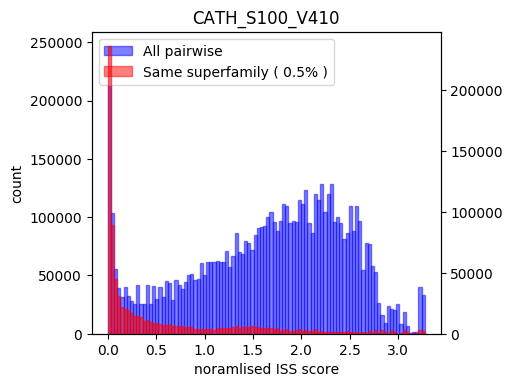

In [34]:
import matplotlib
%matplotlib inline
matplotlib.use("Agg")
from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# kwargs = {
#     'projection':'3d',
# }



kwargs = {'ylabel':'count',
          'xlabel':'noramlised ISS score',
         'title':'CATH_S100_V410',
         }
plt.close()
siz = [450,400]
DPI=100.
fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)
ax1b = ax1.twinx()
# ax1.set_yscale('log')
# ax1.set_xscale('log')

# vals = np.maximum(0,vdata)
# lbls = [None]

lbl = 'All pairwise'
kargs = {'label':lbl}

vals = np.ma.array(vdata,mask = None)

binsA1 = ax1.hist( vals,100, 
    edgecolor = 'b',facecolor = 'b',
    # edgecolor = 'r',facecolor = 'r',
#     marker ='o',
    # c = colors,
#      s =100,
     alpha = 0.5,
     **kargs
#     label = ''
     )



lbl = 'Same superfamily ( 0.5% )'
vals = np.delete(np.array(vdata), (sfbools) )

kargs = {'label': lbl}

vals = np.array(vdata)[sfbools]

binsB1 = ax1b.hist( vals,100, 
    edgecolor = 'r',facecolor = 'r',
    # edgecolor = 'r',facecolor = 'r',
#     marker ='o',
    # c = colors,
#      s =100,
     alpha = 0.5,
     **kargs
     )
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()

ax1.legend(lines + lines2,
           labels + labels2,
           loc = 2)
# ax1.legend( )
# ax1b.legend( )
# ax1.legend( loc = 1)
# ax1b.legend(loc = 2 )
# plt.legend()

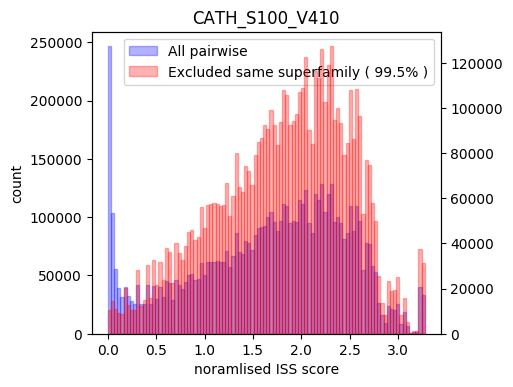

In [37]:
import matplotlib
%matplotlib inline
matplotlib.use("Agg")
from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
# kwargs = {
#     'projection':'3d',
# }



kwargs = {'ylabel':'count',
          'xlabel':'noramlised ISS score',
         'title':'CATH_S100_V410',
         }
plt.close('all')
siz = [450,400]
DPI=100.
fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)
ax1b = ax1.twinx()
# ax1.set_yscale('log')
# ax1.set_xscale('log')

# vals = np.maximum(0,vdata)
# lbls = [None]

lbl = 'All pairwise'
kargs = {'label':lbl}

vals = np.ma.array(vdata,mask = None)

binsA1 = ax1.hist( vals,100, 
    edgecolor = 'b',facecolor = 'b',
    # edgecolor = 'r',facecolor = 'r',
#     marker ='o',
    # c = colors,
#      s =100,
     alpha = 0.3,
     **kargs
#     label = ''
     )



lbl = 'Excluded same superfamily ( 99.5% )'
# vals = np.delete(np.array(vdata), (sfbools) )
vals = np.array(vdata)[notlist(sfbools)]


kargs = {'label': lbl}

# vals = np.array(vdata)[sfbools]

binsB1 = ax1b.hist( vals,100, 
    edgecolor = 'r',facecolor = 'r',
    # edgecolor = 'r',facecolor = 'r',
#     marker ='o',
    # c = colors,
#      s =100,
     alpha = 0.3,
     **kargs
     )
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax1b.get_legend_handles_labels()

ax1.legend(lines + lines2,
           labels + labels2,
           loc =0)
# ax1.legend( )
# ax1b.legend( )
# ax1.legend( loc = 1)
# ax1b.legend(loc = 2 )
# plt.legend()

In [33]:
#### domutil!!


[False, False, True]

In [31]:
vals = np.ma.array(vdata,mask = None)
print len(vals)
vals = np.array(vdata), (sfbools) )
print len(vals)


6555856
6555854


/home/shouldsee/.local/lib/python2.7/site-packages/ipykernel_launcher.py:3: FutureWarning: in the future insert will treat boolean arrays and array-likes as boolean index instead of casting it to integer
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
sum(sfbools)/ float(len(sfbools))

0.005766717966892044

In [73]:
%%time
# sDnorm[0]
# using_coo_izip
D_curr = D_norm
# D_curr = D_raw

xdata = []
ydata = []
vdata = []
sfbools = []
for x,y,v in using_tocoo_izip(D_curr):
    xdata.append(x)
    ydata.append(y)
    vdata.append(v)
    sfbools.append(sfs[x]==sfs[y])

CPU times: user 11.5 s, sys: 536 ms, total: 12.1 s
Wall time: 12 s


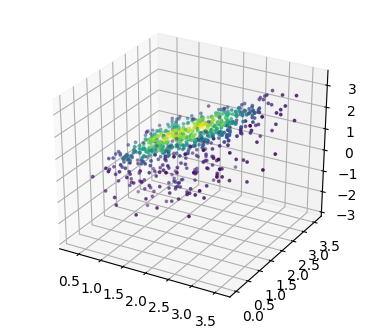

In [75]:
from scipy import stats


import matplotlib
%matplotlib inline
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
kwargs = {
    'projection':'3d',
}
plt.close()
siz = [450,400]
DPI=100.
fig = plt.figure(figsize = [x/float(DPI) for x in siz], dpi=DPI)
ax1 = fig.add_subplot(111,**kwargs)
# idx = range(1000)

N = 700

xss = [hcounts[xi] for xi in xdata]
yss = [hcounts[xi] for xi in ydata]
zss = np.array(vdata)

# xss = np.array(xss)
# yss = np.array(yss) 
# zss = np.array(zss)

# idx = sfbools
# xss = np.delete(xss,idx)
# yss = np.delete(yss,idx)
# zss = np.delete(zss,idx)

xss= np.array(xss[:N])
yss = np.array(yss[:N])
zss = np.array(zss[:N])

xss = np.log10(xss+1)
yss = np.log10(yss+1)
# zss = np.log10(zss+1)

xyz = np.vstack([xss,yss,zss])
kde = stats.gaussian_kde(xyz)
# ax1.set_zlim([0,2000])

ax1.scatter(xss,yss,zss,'.',3, c = kde([xss,yss,zss]))

X = np.linspace(xss.min(), xss.max(),30)
Y = np.linspace(yss.min(), yss.max(),30)
# Z = np.linspace(zss.min(), zss.max(),30)
# Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = (X + Y) / 2 - 2
# surf = ax1.plot_surface(X, Y, Z, cmap=cm.coolwarm, alpha = 0.5, 
#                        linewidth=0, antialiased=False)

In [54]:
# type(hmms)
# hmms[2775]
# hmmid1

<HMMprofile: HMM for 3.30.40.20.1.0 >

In [62]:
type( lst[1][0])

numpy.int32

In [ ]:
%%time
# sDnorm[0]
# using_coo_izip
D_curr = D_norm
# D_curr = D_raw

xdata = []
ydata = []
vdata = []
sfbools = []
for x,y,v in using_tocoo_izip(D_curr):
    xdata.append(x)
    ydata.append(y)
    vdata.append(v)
    sfbools.append(sfs[x]==sfs[y])

In [109]:
%%time
# lst = sorted_D_norm
# ?lst = 
D_curr = D_norm
sorted_D_norm = sort_coo(D_curr.tocoo(),order = 1)

CPU times: user 11.9 s, sys: 340 ms, total: 12.2 s
Wall time: 12 s


In [124]:
%%time
# sDnorm[0]
# using_coo_izip
# D_curr = D_norm
# D_curr = D_raw
# it = using_tocoo_izip(D_curr)
it = sorted_D_norm

xdata = []
ydata = []
vdata = []
sfbools = []
for x,y,v in it:
    xdata.append(x)
    ydata.append(y)
    vdata.append(v)
    sfbools.append(sfs[x]==sfs[y])

CPU times: user 4.36 s, sys: 60 ms, total: 4.42 s
Wall time: 4.41 s


In [132]:
%%time
it = izip(
# using_tocoo_izip(D_norm),
sorted_D_norm,
sfbools,    
)
lst = sfbools
# c = counter(lst,per = 1)
D_curr = D_raw.todok()

CPU times: user 2.56 s, sys: 128 ms, total: 2.69 s
Wall time: 2.69 s


In [121]:
reset_database_connection()

In [165]:
i = 0
c = counter([],INF = 1, per = 10 )
for (hmmid1,hmmid2,v),sfbool in it:
    c.count()   
    if sfbool:
        continue
    
    print v
    raw = D_curr[hmmid1,hmmid2]
    hmmid1 = int(hmmid1)
    hmmid2 = int(hmmid2)
    hmm1 = hmms.get(id = hmmid1 + 1)
    hmm2 = hmms.get(id = hmmid2 + 1)
#     raise
#     if hmm1.cath_node.parent == hmm2.cath_node.parent:
    cnode1 = hmm1.cath_node
    cnode2 = hmm2.cath_node
#     if cnode1.Class == cnode2.Class:
#     if cnode1.topo == cnode2.topo:
    
    if cnode1.homsf == cnode2.homsf:
        continue
    if cnode1.superfamily() in ['3.30.200.20', '1.10.10.530']:
        continue
    
#     if c.i >= 2:
    i+=1
    print hmm1
    print hmm2
    print "norm ISS is %s"%v
    print "raw ISS is %d"%raw
    print hmm1.hits.count() + hmm2.hits.count()
    
    print "http://xhits.cathdb.info/crosshits.php?sf2=%s&sf1=%s&db_source=Crosshits_v4_1_0"%(cnode1.superfamily(),cnode2.superfamily())
    if i == 10:
        break

0 of -1
0.000786053575499
HMM for 3.40.50.720.1.0 
HMM for 3.50.50.60.67.0 
norm ISS is 0.000786053575499
raw ISS is 551
1322
http://xhits.cathdb.info/crosshits.php?sf2=3.40.50.720&sf1=3.50.50.60&db_source=Crosshits_v4_1_0
0.000786053575499
HMM for 3.40.50.720.1.0 
HMM for 3.50.50.60.44.0 
norm ISS is 0.000786053575499
raw ISS is 551
1420
http://xhits.cathdb.info/crosshits.php?sf2=3.40.50.720&sf1=3.50.50.60&db_source=Crosshits_v4_1_0
10 of -1
20 of -1
30 of -1
40 of -1
50 of -1
60 of -1
70 of -1
80 of -1
90 of -1
100 of -1
110 of -1
120 of -1
130 of -1
140 of -1
150 of -1
160 of -1
170 of -1
180 of -1
190 of -1
200 of -1
210 of -1
220 of -1
230 of -1
240 of -1
250 of -1
260 of -1
270 of -1
280 of -1
290 of -1
300 of -1
310 of -1
320 of -1
0.000806989049606
HMM for 1.10.510.10.29.0 
HMM for 3.30.420.40.31.0 
norm ISS is 0.000806989049606
raw ISS is 1612
4098
http://xhits.cathdb.info/crosshits.php?sf2=1.10.510.10&sf1=3.30.420.40&db_source=Crosshits_v4_1_0
0.000806989049606
0.000806989049

HMM for 1.10.510.10.108.0 
HMM for 3.30.420.40.31.0 
norm ISS is 0.0010749868902
raw ISS is 1613
4100
http://xhits.cathdb.info/crosshits.php?sf2=1.10.510.10&sf1=3.30.420.40&db_source=Crosshits_v4_1_0
4930 of -1
0.00107565251744
HMM for 1.10.510.10.55.0 
HMM for 3.30.420.40.31.0 
norm ISS is 0.00107565251744
raw ISS is 1612
4099
http://xhits.cathdb.info/crosshits.php?sf2=1.10.510.10&sf1=3.30.420.40&db_source=Crosshits_v4_1_0


In [29]:
test__norm(D_norm,hmms)
test__raw(D_raw,hmms)

[OK] HMM for 3.50.50.60.129.0  against HMM for 3.40.50.150.190.0  overlaps:: Expected:1.43216726944, Actual:1.43216726944
0 of -1
[OK] HMM for 2.60.120.330.3.0  against HMM for 3.40.1110.10.5.0  overlaps:: Expected:0.929418925714, Actual:0.929418925714
[OK] HMM for 3.40.50.2300.147.0  against HMM for 3.40.50.1820.150.0  overlaps:: Expected:2.2121876044, Actual:2.2121876044
[OK] HMM for 3.40.50.1220.8.0  against HMM for 3.40.50.720.299.0  overlaps:: Expected:1.83884909074, Actual:1.83884909074
[OK] HMM for 3.50.50.60.148.0  against HMM for 3.40.50.1220.23.0  overlaps:: Expected:2.15533603747, Actual:2.15533603747


In [166]:
compare_hits(hmm1,hmm2)

intersection count is 1612
HMM for 1.10.510.10.55.0 ,	 domain:1x8bA02	 length:186,	 hitnum:1616
HMM for 3.30.420.40.31.0 ,	 domain:4a2bA01	 length:146,	 hitnum:2483
1lufA02 147.4 1lufA02 53.4
0 0
200 87
3i7bA02 166.1 3i7bA02 54.3
0 0
174 61
2gnhA01 173.3 2gnhA01 47.1
13 10
195 77
2srcA04 161.4 2srcA04 50.8
0 0
171 61
1yrpB02 165.6 1yrpB02 53.3
0 0
179 56
2oicD02 143.5 2oicD02 66.1
0 0
193 66
4bf2A02 166.1 4bf2A02 50.3
1.10.510.10.70.0
0 0
182 66
1oi9C02 179.6 1oi9C02 50.7
0 0
208 62
4cdsA02 175.2 4cdsA02 60.1
0 0
178 65
2jgzA02 177.4 2jgzA02 50.8
0 0
204 62
2erzE01 169.2 2erzE01 42.7
26 10
210 92
4b8lA02 160.9 4b8lA02 55.3
0 0
170 59
2jc6A02 186.5 2jc6A02 50.8
0 0
179 65
3l9mA01 170.9 3l9mA01 44.3
26 10
210 92
2xirA02 165.4 2xirA02 52.3
0 0
192 79
1yi6B02 164.5 1yi6B02 53.8
0 0
183 63
3e62A02 142.6 3e62A02 59.1
0 0
191 64
3lj0B02 135.5 3lj0B02 46.5
0 0
212 66
4cjyD02 164.5 4cjyD02 57.2
0 0
203 61
3ocsA02 146.9 3ocsA02 59.0
0 0
176 64
2f57A02 173.5 2f57A02 57.6
0 0
179 62
3tjdA02 142.6 

3dkgA02 151.1 3dkgA02 57.6
0 0
179 64
1gy3C02 179.6 1gy3C02 50.7
0 0
208 62
3ag9A01 169.4 3ag9A01 42.8
13 9
195 77
4eomA02 180.1 4eomA02 51.1
0 0
208 62
1ua2D02 151.2 1ua2D02 56.6
0 0
205 61
4c58A02 141.2 4c58A02 55.9
0 0
187 65
3h10A02 175.6 3h10A02 53.9
0 1
171 59
1xh7A01 167.9 1xh7A01 41.3
13 9
195 77
3hkoA02 151.4 3hkoA02 49.4
1.10.510.10.64.0
0 4
231 103
4a07A02 164.2 4a07A02 57.0
0 0
182 59
3i7cA02 159.5 3i7cA02 51.7
0 0
174 61
2gniA01 173.3 2gniA01 47.1
13 10
195 77
2oidB02 143.5 2oidB02 66.1
0 0
193 66
2p2hA02 164.2 2p2hA02 52.3
0 0
192 79
4fuyA02 180.2 4fuyA02 53.3
0 0
212 61
3g0eA02 160.7 3g0eA02 49.3
0 0
198 81
2f7xE01 170.5 2f7xE01 42.9
26 10
210 92
3zclA02 156.2 3zclA02 59.8
1.10.510.10.14.0
0 0
179 64
3f7zB02 146.6 3f7zB02 42.4
2 4
210 65
3l9mB01 170.9 3l9mB01 44.3
26 10
210 92
4anlA02 144.3 4anlA02 43.4
0 0
188 72
3e64A02 142.6 3e64A02 59.1
0 0
191 64
2w9zB02 167.0 2w9zB02 60.6
0 0
197 62
3lj1B02 135.5 3lj1B02 46.5
0 0
212 66
4ckiA02 150.8 4ckiA02 46.7
0 0
199 87
3octA02

3g33A02 168.4 3g33A02 60.6
0 0
197 62
3ppzB02 161.5 3ppzB02 64.5
0 0
182 66
3fhiA01 167.1 3fhiA01 42.7
25 9
209 91
1o6lA01 178.7 1o6lA01 51.2
0 0
180 59
2w9fB02 166.2 2w9fB02 60.6
0 0
197 62
4o2zA02 170.0 4o2zA02 46.1
1 1
206 59
4cfxC02 179.6 4cfxC02 50.7
0 0
208 62
3dqwD02 167.9 3dqwD02 55.9
0 0
184 65
3sdjC02 137.1 3sdjC02 46.6
0 0
208 66
4ks8A02 177.9 4ks8A02 53.2
0 0
179 62
4gfmA02 142.6 4gfmA02 59.1
0 0
191 64
2zoqA02 184.4 2zoqA02 54.4
0 0
212 61
4dawA02 177.3 4dawA02 57.7
0 0
181 63
3kfaA02 162.6 3kfaA02 51.1
1.10.510.10.6.0
0 0
176 65
3brbA02 145.7 3brbA02 50.1
0 0
180 69
4c59A02 115.0 4c59A02 56.3
1.10.510.10.102.0
0 0
156 65
3gc8A02 167.6 3gc8A02 47.3
0 0
204 57
3f5pT02 150.6 3f5pT02 51.8
0 0
188 76
1xh8A01 169.4 1xh8A01 42.8
13 9
195 77
1k3aA02 144.2 1k3aA02 45.7
0 0
185 73
2lavA02 69.6 2lavA02 39.3
0 0
195 59
4p7eA02 142.6 4p7eA02 59.1
0 0
191 64
2gnjA01 172.6 2gnjA01 46.5
13 9
195 77
2nryD02 145.0 2nryD02 66.1
0 0
193 66
4o0yA02 172.9 4o0yA02 52.5
0 0
180 62
3idbA01 169.2 

1jstA02 179.6 1jstA02 50.6
0 0
208 62
2gqgA02 162.2 2gqgA02 50.6
0 0
181 65
2oh4A02 164.3 2oh4A02 52.5
0 0
191 78
4ftcA02 142.8 4ftcA02 49.7
1 1
174 52
3pwyA02 167.4 3pwyA02 56.6
0 0
182 59
3tl8D02 129.6 3tl8D02 62.6
0 0
198 69
4ec8A02 146.5 4ec8A02 47.7
0 0
213 61
3e8eL01 169.4 3e8eL01 42.8
13 9
195 77
2qu6A02 164.2 2qu6A02 52.3
0 0
192 79
4c4fA02 154.3 4c4fA02 36.8
0 0
191 56
2helA02 153.2 2helA02 55.6
0 0
181 64
4f1mA02 124.7 4f1mA02 44.3
0 0
180 66
4j1rB02 146.6 4j1rB02 42.4
2 4
210 65
3sdjE02 137.1 3sdjE02 46.6
0 0
208 66
4aqcA02 142.6 4aqcA02 59.1
0 0
191 64
4dh5A01 167.7 4dh5A01 41.2
25 10
209 91
1jsuA02 179.6 1jsuA02 50.6
0 0
208 62
3kvxA02 163.2 3kvxA02 48.8
0 0
213 57
3nnxA02 172.7 3nnxA02 49.0
0 0
204 58
2b4sB02 152.1 2b4sB02 49.7
0 0
189 73
4cxaA02 167.4 4cxaA02 56.8
0 0
209 61
4ibmA02 153.6 4ibmA02 49.7
0 0
190 73
1xh9A01 172.0 1xh9A01 44.4
25 10
209 91
4ogrE02 146.6 4ogrE02 47.8
0 0
213 61
3cp9A02 164.2 3cp9A02 52.3
0 0
192 79
3hx4A03 187.6 3hx4A03 53.1
0 0
181 60
4fv3A02

191 65
3a7gA02 184.4 3a7gA02 60.1
0 0
179 62
3dk6A02 164.5 3dk6A02 51.0
0 0
183 65
4ivbA02 142.4 4ivbA02 59.0
0 0
190 64
2i6lB02 156.6 2i6lB02 46.2
0 0
208 59
3qcxA02 165.7 3qcxA02 57.0
0 0
182 59
2y94A02 188.8 2y94A02 73.9
0 0
178 63
3tl8G02 129.5 3tl8G02 62.6
0 0
198 69
3f5pB02 150.6 3f5pB02 51.8
0 0
188 76
3fupA02 142.6 3fupA02 59.1
0 0
191 64
2vnyA01 169.4 2vnyA01 42.9
26 10
210 92
1u5rB02 157.0 1u5rB02 52.4
0 0
179 63
2vz6A02 182.0 2vz6A02 44.7
0 0
186 65
3uc3A02 160.3 3uc3A02 49.0
0 0
186 63
4c4jA02 154.3 4c4jA02 36.8
0 0
191 56
2jamB02 187.4 2jamB02 51.0
1.10.510.10.29.0
0 0
191 64
1sykB01 167.2 1sykB01 42.7
25 9
209 91
3fxzA02 175.3 3fxzA02 55.4
0 0
180 62
3hgkB02 127.7 3hgkB02 67.2
0 0
192 65
1h24A02 179.7 1h24A02 50.7
0 0
208 62
3sdjG02 137.1 3sdjG02 46.6
0 0
208 66
4dh7A01 167.7 4dh7A01 41.2
25 10
209 91
2hk5A02 167.6 2hk5A02 50.9
0 0
175 65
3comA02 174.5 3comA02 57.3
0 0
183 64
3mfrA02 176.3 3mfrA02 50.0
0 0
189 63
2yabA02 168.4 2yabA02 53.4
0 0
184 57
4eoiC02 181.4 4eoiC02

3rwpA02 165.7 3rwpA02 57.0
0 0
182 59
2baqA02 173.0 2baqA02 48.4
0 0
204 58
2uzeC02 179.6 2uzeC02 50.6
0 0
208 62
1ctpE01 169.4 1ctpE01 42.9
16 4
200 82
4mq1B02 151.5 4mq1B02 37.6
4 3
252 72
2xckA02 165.7 2xckA02 57.0
0 0
182 59
4fstA02 143.0 4fstA02 50.0
1 1
174 53
3fbvH02 137.1 3fbvH02 46.6
0 0
208 66
3lxnA02 141.9 3lxnA02 56.3
0 0
190 62
1ob3A02 172.8 1ob3A02 54.8
0 0
205 61
3e8cF01 169.4 3e8cF01 42.8
13 9
195 77
2rkuA02 189.6 2rkuA02 55.6
0 0
172 59
2hw7A02 162.0 2hw7A02 52.5
0 0
212 63
3f61A02 149.8 3f61A02 49.6
0 0
183 61
4dc2A02 164.9 4dc2A02 52.4
0 0
190 59
3dfaA02 199.1 3dfaA02 57.5
0 0
182 62
2ycrA02 184.2 2ycrA02 57.8
0 0
189 65
3ac1A02 165.5 3ac1A02 56.0
0 0
184 65
1nxkC02 165.7 1nxkC02 43.6
0 0
191 64
3kmuA02 79.8 3kmuA02 21.8
0 0
174 66
3a7hA02 184.4 3a7hA02 60.1
0 0
179 62
4ivcA02 142.4 4ivcA02 59.0
0 0
190 64
3qd0A02 165.7 3qd0A02 57.0
0 0
182 59
4ftnA02 142.8 4ftnA02 49.7
1 1
174 52
4bcpA02 179.6 4bcpA02 50.7
0 0
208 62
2w5aA02 179.0 2w5aA02 11.0
1.10.510.10.23.0
19 0


190 66
4fr4A02 157.1 4fr4A02 56.2
1.10.510.10.81.0
0 0
183 61
1oiuC02 178.1 1oiuC02 51.1
0 0
177 62
4cfuA02 179.6 4cfuA02 50.7
0 0
208 62
3f5pG02 150.6 3f5pG02 51.8
0 0
188 76
2uw4A01 170.9 2uw4A01 44.4
26 10
210 92
3c0iA02 164.9 3c0iA02 42.3
1.10.510.10.53.0
0 0
189 63
2a19B02 136.9 2a19B02 53.3
0 0
175 65
4appA02 172.9 4appA02 52.5
0 0
180 62
1xhaA01 169.6 1xhaA01 41.7
14 6
197 79
4mq1C02 151.5 4mq1C02 37.6
2 2
250 70
4u6rA02 126.3 4u6rA02 40.3
0 1
191 64
4bcgA02 146.6 4bcgA02 47.8
0 0
213 61
3fbvJ02 137.1 3fbvJ02 46.6
0 0
208 66
3lxpA02 141.9 3lxpA02 56.3
0 0
190 62
3nusA02 165.7 3nusA02 57.0
0 0
182 59
2pvjA01 132.1 2pvjA01 44.9
16 15
234 74
2uw5A01 169.4 2uw5A01 42.9
26 10
210 92
3bu3A02 152.1 3bu3A02 49.7
0 0
189 73
4fg8B02 191.5 4fg8B02 52.5
0 0
185 66
2ozaA02 174.8 2ozaA02 44.5
0 0
189 63
2cchC02 179.6 2cchC02 50.7
0 0
208 62
4izaA02 181.2 4izaA02 54.5
0 0
212 61
4or5F02 146.6 4or5F02 47.7
0 0
213 61
3qhrA02 179.6 3qhrA02 50.7
0 0
208 62
3vn9A02 154.1 3vn9A02 46.5
0 1
188 66
4n

4h05A02 12.4 4h05A02 11.3
3.90.1200.10.4.0
5 8
162 111
1fvrA02 150.3 1fvrA02 59.3
0 0
193 79
3f5pI02 150.6 3f5pI02 51.8
0 0
188 76
2a1aB02 136.9 2a1aB02 53.3
0 0
175 65
4aguA02 173.6 4aguA02 50.0
0 0
207 61
4gl9A02 143.4 4gl9A02 61.4
0 0
191 64
4d0wA02 142.6 4d0wA02 59.1
0 0
191 64
1jbpE01 168.9 1jbpE01 42.7
25 10
209 91
2xruA02 177.7 2xruA02 53.9
0 1
171 59
2jdoA02 178.7 2jdoA02 51.2
0 0
180 59
4g3fA02 126.6 4g3fA02 50.1
1.10.510.10.22.0
0 0
180 59
1yhvA02 175.9 1yhvA02 55.4
0 0
180 62
4imyE02 146.6 4imyE02 47.8
0 0
213 61
4bznA02 152.8 4bznA02 48.6
0 0
171 61
3ac3A02 165.5 3ac3A02 56.0
0 0
184 65
4azwA03 34.5 4azwA03 18.2
1 1
147 58
4mq2A02 151.5 4mq2A02 37.6
4 3
252 72
4bciA02 146.6 4bciA02 47.8
0 0
213 61
3zonA02 87.8 3zonA02 33.9
0 0
179 59
2j0jA05 161.7 2j0jA05 46.5
0 0
179 62
3d7zA02 174.4 3d7zA02 49.6
0 0
204 58
2ow3A02 146.5 2ow3A02 42.4
2 4
210 65
4rfzA02 144.8 4rfzA02 58.5
1.10.510.10.3.0
0 0
176 64
3f66A02 156.4 3f66A02 59.9
0 0
179 64
2uw6A01 169.4 2uw6A01 42.9
26 10
210 9

In [16]:
hmmids = list(hmms.values_list('id',flat = True))

In [46]:
key_v = sorted_D_norm[0]
print key_v
# D_temp = D_norm.toarray()

(2775, 19584, -3.2755416884013093)


In [16]:
D_temp[D_temp.nonzero()]
# D_temp

array([2, 3, 3, ..., 4, 1, 3])

In [129]:
# hmmid1,hmmid2, v = key_v
# hmmid1 += 1
# hmmid2 += 

hmm1 = HMMprofile.objects.get(id = hmmid1  )
hmm2 = HMMprofile.objects.get(id = hmmid2  )

inter_hitseq = hmm1.hits.all() & hmm2.hits.all()
hits1 = hmm1.hit4hmm2hsp_set.filter(target__in = inter_hitseq)
hits2 = hmm2.hit4hmm2hsp_set.filter(target__in = inter_hitseq)


fmt = "%s,\t domain:%s\t length:%s,\t hitnum:%d"
print "intersection count is",inter_hitseq.count()
print  fmt %(hmm1,hmm1.cath_node.domain, p_hmmlen.findall(hmm1.text)[0], hmm1.hits.count() )
print fmt % (hmm2,hmm2.cath_node.domain, p_hmmlen.findall(hmm2.text)[0], hmm2.hits.count() )
for i,j in zip(hits1,hits2):
    try:
        node =  domain.objects.get(domain_id = i.target.acc).classification
    except:
        node = ''
    print i.target.acc,i.bitscore,
    print j.target.acc,j.bitscore
#     print node
    print i.start,j.start
    print i.end,j.end

intersection count is 0
HMM for 1.20.120.390.1.0 ,	 domain:2icwG01	 length:124,	 hitnum:2
HMM for 2.60.40.10.267.0 ,	 domain:2xy1A02	 length:94,	 hitnum:3480


In [25]:
# isinstance(
type(hmm1.hits.all())

django.db.models.query.QuerySet

In [86]:
hits1_ids = hmm1.hits.values_list('id',flat = 1)
hits2_ids = hmm2.hits.values_list('id',flat = 1)
inter_hitseq = set( hits1_ids ) & set( hits2_ids )

hits1 = list(hmm1.hit4hmm2hsp_set.filter(target__id__in = inter_hitseq))
hits2 = list(hmm2.hit4hmm2hsp_set.filter(target__id__in = inter_hitseq))

fmt = "%s,\t domain:%s\t length:%s,\t hitnum:%d"
for i,j in zip(hits1,hits2):
    print i.target.acc,i.bitscore,
    print j.target.acc,j.bitscore
#     print node
    print i.start,j.start
    print i.end,j.end

1gn0A00 73.6 1gn0A00 12.4
0 7
105 96


In [68]:
hmm2.hits.count()#
hmm2.hit4hmm2hsp_set.con

123

In [139]:
compare_hits(hmm1,hmm2)
# hmm1.hits.all() 

intersection count is 2594
HMM for 1.10.10.530.1.0 ,	 domain:2icwG02	 length:89,	 hitnum:2596
HMM for 2.60.40.10.230.0 ,	 domain:2xy2A02	 length:95,	 hitnum:3455
3juyA01 81.8 3juyA01 27.7
0 3
77 116
4lciL00 58.4 4lciL00 41.4
0 0
73 104
1zanL01 61.4 1zanL01 46.0
0 0
72 97
1cloL01 55.3 1cloL01 48.2
0 0
64 99
2z92A01 65.4 2z92A01 33.9
0 3
78 110
1rziA01 65.2 1rziA01 48.4
0 0
66 106
4nnpH01 85.0 4nnpH01 30.7
0 7
73 112
3cfiL00 77.5 3cfiL00 26.1
0 2
71 114
4ei6D01 40.9 4ei6D01 32.1
2 0
72 106
3p0yL01 60.8 3p0yL01 54.5
0 0
66 107
1etzB01 57.9 1etzB01 26.4
0 2
80 104
1rihL01 58.0 1rihL01 50.7
0 0
67 97
4eowH01 77.3 4eowH01 26.3
0 1
69 110
4whtA01 72.7 4whtA01 24.4
0 4
70 111
1eo8L01 50.6 1eo8L01 44.9
0 0
66 105
2xqyG01 90.3 2xqyG01 29.8
1 5
77 104
3mbxL01 64.1 3mbxL01 42.6
0 0
73 112
4jy6B01 69.0 4jy6B01 25.6
0 3
70 102
3iflH01 60.9 3iflH01 28.4
0 1
80 105
1pg7X01 71.1 1pg7X01 22.4
0 1
71 109
3i02A01 64.3 3i02A01 44.6
0 0
72 112
1z3gL01 55.1 1z3gL01 43.0
0 0
64 105
2x1qA00 71.6 2x1qA00 27.8
0

1figL01 63.1 1figL01 47.0
0 0
66 98
1t2qL01 59.9 1t2qL01 36.4
0 0
76 100
4gxuR01 69.0 4gxuR01 44.3
0 0
71 103
4od3H01 68.9 4od3H01 18.9
0 4
69 103
1lveA00 68.7 1lveA00 40.9
0 0
72 114
1nlbH01 82.0 1nlbH01 26.3
0 2
70 99
1mlbA01 63.0 1mlbA01 54.6
0 0
72 102
2adfL01 62.9 2adfL01 46.1
0 0
67 106
3t0wA00 60.1 3t0wA00 37.0
0 0
69 99
2z8vC00 18.4 2z8vC00 35.3
1 0
70 98
4ffvD01 72.4 4ffvD01 34.5
0 1
71 117
2nw2A01 37.4 2nw2A01 29.5
0 0
66 100
3zl4H01 77.8 3zl4H01 30.5
0 1
81 117
4hpoL01 56.5 4hpoL01 39.9
0 1
69 109
1ospH01 56.0 1ospH01 30.6
0 1
68 107
2j4wH01 78.3 2j4wH01 24.5
0 5
70 105
2imnA00 66.3 2imnA00 42.8
0 0
76 103
4p2qE01 31.2 4p2qE01 27.2
1 1
73 107
1sm3L01 39.3 1sm3L01 32.2
0 1
68 108
3kdmH01 83.2 3kdmH01 27.6
0 6
70 99
3rvvD01 69.4 3rvvD01 31.4
0 1
79 103
4nikB02 69.5 4nikB02 41.5
0 0
72 100
3so3B01 72.1 3so3B01 40.3
0 0
68 99
4jb9L01 54.2 4jb9L01 36.3
0 0
71 94
4k3dI01 71.5 4k3dI01 37.7
0 2
71 116
3u9pH01 75.8 3u9pH01 27.5
0 1
71 106
4a6yB01 90.4 4a6yB01 31.3
0 1
71 110
1nfdF01 

3tnnB01 65.1 3tnnB01 39.3
0 0
71 102
4fqcH01 72.3 4fqcH01 27.8
0 2
70 103
1fptH01 78.9 1fptH01 26.9
0 0
70 100
4mxvF01 84.7 4mxvF01 34.4
0 5
70 100
1t7vA02 10.9 1t7vA02 19.4
0 0
62 86
4eupH01 39.5 4eupH01 15.1
1 0
76 102
4kmtH01 83.3 4kmtH01 21.7
0 0
69 103
2aj3A01 44.2 2aj3A01 43.5
0 0
66 101
2xwtA01 84.3 2xwtA01 23.6
0 0
69 104
3bjlB01 61.7 3bjlB01 43.9
0 0
70 109
4l3eD01 48.0 4l3eD01 39.2
0 0
70 108
3qpqF01 85.7 3qpqF01 34.7
0 1
70 100
3ncyP01 86.0 3ncyP01 22.3
0 0
71 103
3qcuH01 73.0 3qcuH01 20.1
0 0
69 106
1kenL01 64.3 1kenL01 43.3
0 0
69 98
1f3dL01 50.5 1f3dL01 33.2
0 0
72 101
2ipuK01 54.3 2ipuK01 34.1
0 0
72 100
4lp5A03 19.5 4lp5A03 57.8
1 1
41 87
4r26L01 38.8 4r26L01 32.0
2 1
61 106
1mj8L01 58.1 1mj8L01 38.4
0 0
71 100
3u4eA01 69.2 3u4eA01 23.6
0 4
66 105
4ebqL01 64.0 4ebqL01 43.1
0 0
65 100
4n1cB00 63.1 4n1cB00 52.9
0 0
67 106
4grwH00 57.7 4grwH00 25.5
0 5
70 110
3mugD01 70.1 3mugD01 17.9
0 4
90 103
4hhaA01 65.2 4hhaA01 38.8
0 0
72 94
4lsqL01 53.7 4lsqL01 48.8
0 0
70 102
1zglM

3o2vL01 57.7 3o2vL01 33.8
0 0
72 100
4gmsH01 76.2 4gmsH01 26.0
0 1
74 104
1xgtB01 61.4 1xgtB01 33.3
0 1
78 112
2jixD01 84.0 2jixD01 35.7
0 1
79 101
4g5zL01 61.4 4g5zL01 46.0
0 0
73 97
4lhjB00 63.7 4lhjB00 34.4
0 5
70 110
1tzhA01 65.5 1tzhA01 56.1
0 0
66 106
1bbjH01 82.7 1bbjH01 31.1
0 0
71 113
1faiH01 81.3 1faiH01 29.5
0 0
81 111
2qadH01 70.9 2qadH01 21.3
0 0
69 107
4dn3H01 71.8 4dn3H01 25.4
0 0
69 103
3okdA01 68.3 3okdA01 43.5
0 0
73 112
4dqoH01 70.1 4dqoH01 17.9
0 4
90 103
4lveB00 68.7 4lveB00 41.2
0 0
73 112
1za3A01 64.2 1za3A01 56.6
0 0
72 106
3eo9L01 66.5 3eo9L01 56.9
0 0
71 106
4hf5H01 78.8 4hf5H01 28.7
0 4
68 112
3gizL01 69.0 3gizL01 43.0
0 0
72 103
3ra7L01 60.6 3ra7L01 46.4
0 0
71 95
3gkzA02 67.1 3gkzA02 47.4
0 1
69 99
1nakL01 59.1 1nakL01 33.2
0 0
72 104
1afvL01 63.4 1afvL01 34.6
0 0
75 109
3q6gI01 74.2 3q6gI01 31.0
0 2
81 107
4a6yA01 39.4 4a6yA01 32.7
0 0
68 101
3ucrA00 12.5 3ucrA00 33.8
1 5
47 109
1mfaH01 86.6 1mfaH01 29.8
0 0
70 97
3l95A01 63.8 3l95A01 52.9
0 0
67 106
1igyA

0 1
71 110
3csyB01 63.8 3csyB01 40.5
0 0
73 104
3mlvL01 54.0 3mlvL01 44.1
0 1
62 107
4qwwC01 58.8 4qwwC01 47.1
0 0
65 104
1tziB01 72.3 1tziB01 30.0
0 5
78 109
2w9dL01 55.0 2w9dL01 44.3
0 0
71 96
3g6jE01 64.0 3g6jE01 53.8
0 0
72 107
3cfdB01 66.9 3cfdB01 32.0
0 1
79 109
3u2sH01 69.2 3u2sH01 23.6
0 4
66 105
4otxH01 88.3 4otxH01 27.1
0 1
71 112
2qhlD00 50.1 2qhlD00 30.8
2 2
69 107
1k6qL01 57.4 1k6qL01 49.6
0 0
66 98
4gq9H01 84.8 4gq9H01 31.8
0 0
71 117
3ijhB01 76.9 3ijhB01 28.1
0 5
72 104
3cmoX01 57.0 3cmoX01 46.7
0 0
74 106
3vg9C01 78.3 3vg9C01 29.9
0 0
71 108
3rpiB01 55.2 3rpiB01 49.1
0 0
65 90
4j8rA01 55.2 4j8rA01 38.1
0 0
70 105
4kvnH01 73.8 4kvnH01 30.0
0 3
69 101
2r4rL01 57.9 2r4rL01 42.7
0 0
61 97
1jn6B01 86.3 1jn6B01 28.8
0 0
70 107
2h9gB01 76.6 2h9gB01 27.7
0 5
70 101
3b5tA00 47.6 3b5tA00 26.8
2 2
69 107
4fnlH01 65.7 4fnlH01 29.1
0 4
75 113
3dvfA00 65.8 3dvfA00 49.1
0 0
71 97
4hixL01 54.3 4hixL01 35.4
1 0
73 107
3he7D01 44.3 3he7D01 20.3
0 0
73 100
2p46B00 51.8 2p46B00 25.7
0 5
70

2xa8H01 73.4 2xa8H01 30.7
0 5
84 104
4gxuW00 81.4 4gxuW00 24.9
0 4
71 99
1a2yA00 65.8 1a2yA00 52.7
0 0
66 97
1nl0H01 81.4 1nl0H01 29.0
0 4
70 105
3tjhD01 53.4 3tjhD01 27.2
1 2
76 112
1fn4B01 65.2 1fn4B01 30.4
0 5
77 100
2b2xL01 62.1 2b2xL01 49.4
0 0
66 106
4hweH01 83.0 4hweH01 20.1
0 1
70 104
4qhnA01 66.9 4qhnA01 30.8
0 0
79 102
2cjuL00 55.1 2cjuL00 34.4
0 0
72 101
2vxqL01 62.4 2vxqL01 49.7
0 0
69 106
4hgkC00 28.7 4hgkC00 42.8
0 0
69 104
2a77L01 59.5 2a77L01 33.9
0 0
72 102
1pz5A01 60.3 1pz5A01 35.3
0 0
72 111
1lhzB01 56.6 1lhzB01 38.7
0 0
71 110
3i50L01 51.3 3i50L01 38.5
0 0
64 99
1bfvH00 69.6 1bfvH00 24.8
0 3
70 118
3uluF01 87.7 3uluF01 34.9
0 0
71 100
1q72L01 58.6 1q72L01 35.8
0 0
72 105
4fp8H01 65.7 4fp8H01 29.1
0 4
75 113
3l5xL01 65.2 3l5xL01 48.3
0 0
68 107
4l9lB01 47.2 4l9lB01 17.8
1 1
76 104
4m43H01 74.0 4m43H01 29.0
0 3
81 108
4qo1A00 66.3 4qo1A00 30.6
0 1
70 111
2dtgD01 44.2 2dtgD01 43.5
0 0
85 100
3o4lE01 42.0 3o4lE01 38.0
0 0
67 112
4imlB01 61.9 4imlB01 47.0
0 2
66 108
3a6c

1i3gH00 90.9 1i3gH00 30.4
0 0
71 110
4ht1L01 56.7 4ht1L01 47.1
0 0
72 102
4u6hB01 48.5 4u6hB01 31.9
0 0
72 105
2z4qA01 48.8 2z4qA01 31.0
0 0
72 100
3ietB01 75.0 3ietB01 27.3
0 1
72 117
4gmtH01 76.2 4gmtH01 26.0
0 1
74 104
4ozhE01 40.8 4ozhE01 34.3
0 1
69 98
3gk8L01 55.9 3gk8L01 37.4
0 0
72 98
3s96D01 45.3 3s96D01 45.0
0 0
71 105
4o51E01 67.8 4o51E01 49.3
0 0
74 109
3q5yA01 42.8 3q5yA01 20.7
0 0
69 101
3mugJ01 70.1 3mugJ01 17.9
0 4
90 103
4pj9C01 37.4 4pj9C01 30.0
1 1
67 109
4rdqF01 60.0 4rdqF01 54.5
0 0
73 97
1aqkL01 56.0 1aqkL01 42.7
0 0
76 109
3qeqD01 44.8 3qeqD01 28.9
0 0
67 105
1kgcD01 44.6 1kgcD01 34.8
0 1
68 102
1reiA00 63.1 1reiA00 48.4
0 0
66 106
4nugL01 58.9 4nugL01 40.5
0 0
71 100
4u05A00 59.8 4u05A00 28.1
0 7
76 121
3wfdL01 53.5 3wfdL01 46.2
0 0
67 103
1i9jL01 57.0 1i9jL01 35.2
0 0
72 100
4p59L01 67.3 4p59L01 50.5
0 0
71 107
4c83A01 71.2 4c83A01 19.5
0 6
70 104
1t04D01 80.0 1t04D01 22.1
0 3
70 99
4nkmA00 67.0 4nkmA00 32.5
0 0
71 108
2g5bB01 73.0 2g5bB01 27.9
0 7
72 121
1yjdL

4gftB00 56.7 4gftB00 29.2
0 2
71 114
1gafL01 47.2 1gafL01 41.3
0 0
69 104
4ms8C01 62.0 4ms8C01 39.1
0 3
76 116
4jlrB01 65.0 4jlrB01 46.4
0 0
70 94
1a5fH01 86.0 1a5fH01 30.2
0 1
70 100
4hemE00 65.7 4hemE00 29.9
0 5
70 110
1dzbA02 61.5 1dzbA02 43.3
0 0
66 95
3v0wH01 79.1 3v0wH01 30.1
0 6
72 118
4dkaA00 67.4 4dkaA00 31.8
0 2
70 109
2xqbH01 82.2 2xqbH01 22.8
0 0
71 107
4jffD01 42.8 4jffD01 37.0
0 0
73 108
3aazA01 67.9 3aazA01 33.1
0 0
73 111
2fb4H01 80.0 2fb4H01 31.0
0 3
70 110
2a9nH00 73.5 2a9nH00 26.2
0 2
70 108
4x7fD00 59.1 4x7fD00 28.3
0 6
69 114
3v4vH01 88.9 3v4vH01 27.9
0 0
71 108
1l7iL01 64.9 1l7iL01 50.7
0 0
69 101
3hzmA01 67.8 3hzmA01 44.1
0 0
72 111
4jpvH01 71.2 4jpvH01 22.5
0 1
84 121
1g7lA00 65.8 1g7lA00 53.6
0 0
72 102
4gmtL01 51.6 4gmtL01 48.1
0 0
70 105
3i75A01 58.6 3i75A01 44.1
0 0
65 94
2vweC01 53.3 2vweC01 44.9
0 0
71 95
3csyF01 63.8 3csyF01 40.5
0 0
73 104
3mlyL01 69.9 3mlyL01 37.1
0 0
68 101
4bklB01 67.9 4bklB01 34.4
0 0
76 102
4pubL01 66.1 4pubL01 54.9
0 0
69 106
1rzgC

4jpwL01 51.7 4jpwL01 46.3
0 0
69 101
1a7pL00 65.9 1a7pL00 51.7
0 0
66 98
1cd8A00 15.9 1cd8A00 32.2
1 0
75 108
2qqkL01 63.9 2qqkL01 52.7
0 0
72 104
2f53D01 35.3 2f53D01 42.5
0 0
71 104
4g6mL01 64.6 4g6mL01 48.0
0 0
66 93
1ggiL01 68.3 1ggiL01 42.4
0 0
75 109
1fbiP01 52.9 1fbiP01 44.2
0 0
69 94
3m8oH01 71.6 3m8oH01 27.2
0 5
69 118
3qumH01 91.3 3qumH01 23.3
0 0
69 101
2g75A01 75.1 2g75A01 29.6
0 0
69 117
2b1hH01 77.6 2b1hH01 22.6
0 0
71 106
2vl5B01 67.8 2vl5B01 43.9
0 0
81 107
2zpkM01 37.1 2zpkM01 34.2
0 0
66 108
3ntcH01 82.0 3ntcH01 20.4
0 0
80 99
3b9kC01 59.7 3b9kC01 45.3
0 0
70 106
4lgsB00 63.7 4lgsB00 30.3
0 5
70 107
4edxA01 52.2 4edxA01 45.7
0 0
76 98
4ij3C01 74.2 4ij3C01 23.3
0 1
68 104
3c08H01 91.1 3c08H01 23.3
0 0
71 105
4h8wH01 81.9 4h8wH01 27.7
0 5
70 107
2aptA00 54.0 2aptA00 33.0
1 1
78 98
1nmbH00 90.4 1nmbH00 31.5
0 0
71 104
4ogaC00 70.2 4ogaC00 26.9
0 1
78 107
4l8sA01 37.6 4l8sA01 25.1
1 2
69 100
2ombB01 54.1 2ombB01 37.0
1 1
71 101
2aabL01 71.1 2aabL01 37.9
0 0
80 103
3hzyB01

3ks0J01 39.1 3ks0J01 33.0
0 0
67 107
3zknH01 69.9 3zknH01 25.8
0 1
77 115
3fo2B01 72.0 3fo2B01 24.0
0 5
77 99
4kphI01 62.6 4kphI01 35.3
0 1
80 111
1bjmB01 61.7 1bjmB01 43.9
0 0
70 109
3u0wH01 77.6 3u0wH01 21.9
0 9
70 112
4pptA00 50.1 4pptA00 35.6
0 5
70 119
2cmrH01 73.5 2cmrH01 26.7
0 0
68 118
2qr0B01 82.9 2qr0B01 30.0
0 5
72 106
4cmhB01 88.5 4cmhB01 27.8
0 0
71 119
4onhA01 34.7 4onhA01 38.0
0 0
68 100
1ek3A00 70.2 1ek3A00 41.5
0 0
73 103
2j6eH01 73.6 2j6eH01 28.6
0 11
92 112
1j1xL00 60.9 1j1xL00 50.4
0 0
66 97
4f33D01 75.1 4f33D01 21.7
0 1
71 105
4bz2H01 82.9 4bz2H01 28.8
0 1
70 104
4ocxL01 51.8 4ocxL01 31.8
0 0
72 100
1d5iL01 57.9 1d5iL01 47.1
0 0
65 105
3hc3H01 91.1 3hc3H01 27.6
0 0
69 114
1mcbA01 61.2 1mcbA01 37.4
1 0
71 110
2r0lH01 78.3 2r0lH01 27.1
0 5
71 99
2ck0L01 69.5 2ck0L01 46.2
0 0
77 112
12e8H01 75.1 12e8H01 36.5
0 0
71 108
3dusA00 68.9 3dusA00 42.7
0 0
73 111
1ap2B00 81.8 1ap2B00 28.9
0 0
69 105
4okvA01 88.4 4okvA01 29.8
0 0
71 112
3fmgH01 76.5 3fmgH01 24.4
0 0
81 105
3mc

2xzqL01 39.3 2xzqL01 29.8
0 0
67 108
1igcL01 62.5 1igcL01 52.6
0 0
79 103
3rdtB01 52.2 3rdtB01 29.5
0 0
74 98
1u3hA00 47.9 1u3hA00 44.8
0 0
68 109
3qehA01 76.9 3qehA01 21.3
0 0
69 110
4jo4H01 73.6 4jo4H01 28.6
0 3
72 106
3umtA02 49.7 3umtA02 40.1
0 0
69 95
2bmkA01 60.4 2bmkA01 41.3
0 0
65 96
3oauH01 58.7 3oauH01 18.0
0 5
70 106
4p46A01 46.1 4p46A01 44.3
0 0
68 107
4laqH00 40.7 4laqH00 32.2
0 0
53 101
2nr6C01 57.3 2nr6C01 39.8
0 0
72 106
1deeB01 83.2 1deeB01 27.5
0 4
70 102
3sobL01 63.8 3sobL01 53.6
0 0
66 106
2uziH00 77.6 2uziH00 27.6
0 9
70 100
2j88L01 58.4 2j88L01 58.4
0 0
72 106
4g8fB01 47.1 4g8fB01 17.5
0 0
74 104
3mffB01 44.2 3mffB01 19.6
0 0
73 102
1yeeH01 73.9 1yeeH01 24.2
0 1
71 100
4u6vL01 66.5 4u6vL01 51.0
0 0
71 106
4aeiH01 76.7 4aeiH01 23.6
0 6
70 105
3ujjL01 60.3 3ujjL01 49.1
0 2
67 107
4kucH01 84.6 4kucH01 27.3
0 0
66 103
3qjfA01 26.8 3qjfA01 41.8
1 2
73 104
4py7B01 65.0 4py7B01 53.4
0 0
69 99
1f4wL01 40.4 1f4wL01 31.5
0 0
66 108
1c12B01 70.1 1c12B01 33.5
0 1
79 119
4pjgF

3utzD01 50.8 3utzD01 34.2
0 0
72 111
3phoB01 76.6 3phoB01 28.1
0 5
72 108
2ap2A00 67.8 2ap2A00 50.1
1 2
89 104
1qfuL01 59.1 1qfuL01 34.9
0 0
72 102
1pewA00 40.1 1pewA00 38.8
0 1
65 106
3q6fD01 78.8 3q6fD01 27.7
0 2
70 106
3mv8E01 59.2 3mv8E01 33.1
0 0
72 103
3quyC01 32.7 3quyC01 48.6
0 0
74 101
1mexL01 51.2 1mexL01 44.3
0 0
81 105
3nfjH01 43.7 3nfjH01 33.4
0 0
74 106
2ih3A01 81.3 2ih3A01 31.7
0 0
71 117
4bh8B01 84.9 4bh8B01 29.7
0 0
70 107
1s3kH01 83.0 1s3kH01 30.4
0 4
70 108
1cdyA01 13.3 1cdyA01 42.9
0 0
35 97
4gmsJ01 76.2 4gmsJ01 26.0
0 1
74 104
2xtjB00 60.9 2xtjB00 54.2
0 0
67 106
3u7aA00 64.2 3u7aA00 49.4
0 1
74 106
4i13B00 52.2 4i13B00 27.6
0 3
70 111
2oi9C00 52.3 2oi9C00 35.6
0 0
76 97
4evnA01 68.7 4evnA01 25.8
0 0
69 110
4nm4L01 68.5 4nm4L01 41.2
0 0
78 112
2v17L01 52.1 2v17L01 51.8
0 0
67 103
3rgvA01 43.8 3rgvA01 31.3
0 0
68 108
3qq9H01 60.9 3qq9H01 29.0
0 2
77 101
3t2nL01 56.7 3t2nL01 40.0
0 0
68 109
1ohqB00 71.9 1ohqB00 24.5
0 9
70 102
4dkfH01 78.6 4dkfH01 31.2
0 8
71 101
3t6

In [142]:
domain.objects.count()

34106

In [145]:
def compare_hits( hmm1,hmm2):
    hits1_ids = hmm1.hits.values_list('id')
    hits2_ids = hmm2.hits.values_list('id')
    inter_hitseq = set( hits1_ids ) & set( hits2_ids )
    hits1 = hmm1.hit4hmm2hsp_set.prefetch_related('target')
    hits2 = hmm2.hit4hmm2hsp_set.prefetch_related('target')
#     hits2 = hmm2.hit4hmm2hsp_set.filter(target__in = inter_hitseq)
    fmt = "%s,\t domain:%s\t length:%s,\t hitnum:%d"
#     print "intersection count is",inter_hitseq.count()
    print "intersection count is",inter_hitseq.__len__()
    print  fmt %(hmm1,hmm1.cath_node.domain, p_hmmlen.findall(hmm1.text)[0], hmm1.hits.count() )
    print fmt % (hmm2,hmm2.cath_node.domain, p_hmmlen.findall(hmm2.text)[0], hmm2.hits.count() )
#     for i,j in zip(hits1,hits2):
    for hitid in inter_hitseq:
        i = hits1.get(target=hitid)
        j = hits2.get(target=hitid)
        try:
            node =  domain.objects.get(domain_id = i.target.acc).classification
        except Exception as e:
#             print e
            node = ''
        print i.target.acc,i.bitscore,
        print j.target.acc,j.bitscore
        if node: print node
        
        print i.start,j.start
        print i.end,j.end
compare_hits(hmm1,hmm2)
# hits1_ids = hmm1.hits.values_list('id')
# hits2_ids = hmm2.hits.values_list('id')

intersection count is 2594
HMM for 1.10.10.530.1.0 ,	 domain:2icwG02	 length:89,	 hitnum:2596
HMM for 2.60.40.10.230.0 ,	 domain:2xy2A02	 length:95,	 hitnum:3455
3juyA01 81.8 3juyA01 27.7
0 3
77 116
4lciL00 58.4 4lciL00 41.4
0 0
73 104
1zanL01 61.4 1zanL01 46.0
0 0
72 97
1cloL01 55.3 1cloL01 48.2
0 0
64 99
2z92A01 65.4 2z92A01 33.9
0 3
78 110
1rziA01 65.2 1rziA01 48.4
0 0
66 106
4nnpH01 85.0 4nnpH01 30.7
0 7
73 112
3cfiL00 77.5 3cfiL00 26.1
0 2
71 114
4ei6D01 40.9 4ei6D01 32.1
2 0
72 106
3p0yL01 60.8 3p0yL01 54.5
0 0
66 107
1etzB01 57.9 1etzB01 26.4
0 2
80 104
1rihL01 58.0 1rihL01 50.7
0 0
67 97
4eowH01 77.3 4eowH01 26.3
0 1
69 110
4whtA01 72.7 4whtA01 24.4
0 4
70 111
1eo8L01 50.6 1eo8L01 44.9
0 0
66 105
2xqyG01 90.3 2xqyG01 29.8
1 5
77 104
3mbxL01 64.1 3mbxL01 42.6
0 0
73 112
4jy6B01 69.0 4jy6B01 25.6
0 3
70 102
3iflH01 60.9 3iflH01 28.4
0 1
80 105
1pg7X01 71.1 1pg7X01 22.4
0 1
71 109
3i02A01 64.3 3i02A01 44.6
0 0
72 112
1z3gL01 55.1 1z3gL01 43.0
0 0
64 105
2x1qA00 71.6 2x1qA00 27.8
2

2adfL01 62.9 2adfL01 46.1
0 0
67 106
3t0wA00 60.1 3t0wA00 37.0
0 0
69 99
2z8vC00 18.4 2z8vC00 35.3
1 0
70 98
4ffvD01 72.4 4ffvD01 34.5
0 1
71 117
2nw2A01 37.4 2nw2A01 29.5
2.60.40.10.39.0
0 0
66 100
3zl4H01 77.8 3zl4H01 30.5
0 1
81 117
4hpoL01 56.5 4hpoL01 39.9
0 1
69 109
1ospH01 56.0 1ospH01 30.6
0 1
68 107
2j4wH01 78.3 2j4wH01 24.5
0 5
70 105
2imnA00 66.3 2imnA00 42.8
0 0
76 103
4p2qE01 31.2 4p2qE01 27.2
1 1
73 107
1sm3L01 39.3 1sm3L01 32.2
0 1
68 108
3kdmH01 83.2 3kdmH01 27.6
0 6
70 99
3rvvD01 69.4 3rvvD01 31.4
0 1
79 103
4nikB02 69.5 4nikB02 41.5
0 0
72 100
3so3B01 72.1 3so3B01 40.3
0 0
68 99
4jb9L01 54.2 4jb9L01 36.3
0 0
71 94
4k3dI01 71.5 4k3dI01 37.7
2.60.40.10.836.0
0 2
71 116
3u9pH01 75.8 3u9pH01 27.5
0 1
71 106
4a6yB01 90.4 4a6yB01 31.3
0 1
71 110
1nfdF01 71.2 1nfdF01 21.1
0 6
71 104
4webL01 65.2 4webL01 38.8
0 0
78 104
3v0aC00 77.3 3v0aC00 29.0
0 5
81 114
4f37K01 52.6 4f37K01 34.3
0 0
72 100
3cleH01 83.7 3cleH01 27.9
0 1
71 102
1nldH01 78.9 1nldH01 22.8
0 1
77 112
4m7lH01 75

62 86
4eupH01 39.5 4eupH01 15.1
1 0
76 102
4kmtH01 83.3 4kmtH01 21.7
0 0
69 103
2aj3A01 44.2 2aj3A01 43.5
0 0
66 101
2xwtA01 84.3 2xwtA01 23.6
0 0
69 104
3bjlB01 61.7 3bjlB01 43.9
0 0
70 109
4l3eD01 48.0 4l3eD01 39.2
0 0
70 108
3qpqF01 85.7 3qpqF01 34.7
0 1
70 100
3ncyP01 86.0 3ncyP01 22.3
0 0
71 103
3qcuH01 73.0 3qcuH01 20.1
0 0
69 106
1kenL01 64.3 1kenL01 43.3
0 0
69 98
1f3dL01 50.5 1f3dL01 33.2
0 0
72 101
2ipuK01 54.3 2ipuK01 34.1
0 0
72 100
4lp5A03 19.5 4lp5A03 57.8
2.60.40.10.620.0
1 1
41 87
4r26L01 38.8 4r26L01 32.0
2 1
61 106
1mj8L01 58.1 1mj8L01 38.4
0 0
71 100
3u4eA01 69.2 3u4eA01 23.6
0 4
66 105
4ebqL01 64.0 4ebqL01 43.1
0 0
65 100
4n1cB00 63.1 4n1cB00 52.9
0 0
67 106
4grwH00 57.7 4grwH00 25.5
0 5
70 110
3mugD01 70.1 3mugD01 17.9
0 4
90 103
4hhaA01 65.2 4hhaA01 38.8
0 0
72 94
4lsqL01 53.7 4lsqL01 48.8
0 0
70 102
1zglM01 45.7 1zglM01 27.7
0 1
72 100
1fh5H01 68.9 1fh5H01 22.4
0 4
64 100
1qokA01 75.8 1qokA01 32.6
0 0
72 106
3vi3E01 49.3 3vi3E01 34.7
0 0
71 100
4ki5E01 83.9 4ki5E

1qfwM00 57.0 1qfwM00 50.5
0 0
85 104
3uc0L01 62.1 3uc0L01 57.5
0 0
68 105
4pjxE01 38.0 4pjxE01 28.8
0 2
69 102
4i77L01 67.6 4i77L01 48.2
0 0
71 110
2dquL01 50.5 2dquL01 32.2
0 0
72 100
3o2vL01 57.7 3o2vL01 33.8
0 0
72 100
4gmsH01 76.2 4gmsH01 26.0
0 1
74 104
1xgtB01 61.4 1xgtB01 33.3
0 1
78 112
2jixD01 84.0 2jixD01 35.7
0 1
79 101
4g5zL01 61.4 4g5zL01 46.0
0 0
73 97
4lhjB00 63.7 4lhjB00 34.4
0 5
70 110
1tzhA01 65.5 1tzhA01 56.1
0 0
66 106
1bbjH01 82.7 1bbjH01 31.1
0 0
71 113
1faiH01 81.3 1faiH01 29.5
0 0
81 111
2qadH01 70.9 2qadH01 21.3
0 0
69 107
4dn3H01 71.8 4dn3H01 25.4
0 0
69 103
3okdA01 68.3 3okdA01 43.5
0 0
73 112
4dqoH01 70.1 4dqoH01 17.9
0 4
90 103
4lveB00 68.7 4lveB00 41.2
0 0
73 112
1za3A01 64.2 1za3A01 56.6
0 0
72 106
3eo9L01 66.5 3eo9L01 56.9
0 0
71 106
4hf5H01 78.8 4hf5H01 28.7
0 4
68 112
3gizL01 69.0 3gizL01 43.0
0 0
72 103
3ra7L01 60.6 3ra7L01 46.4
0 0
71 95
3gkzA02 67.1 3gkzA02 47.4
0 1
69 99
1nakL01 59.1 1nakL01 33.2
0 0
72 104
1afvL01 63.4 1afvL01 34.6
0 0
75 109
3q6g

1mfaL01 37.7 1mfaL01 33.7
0 0
67 108
1jvkA01 56.6 1jvkA01 38.7
0 0
71 110
3l95B01 85.8 3l95B01 29.9
0 5
80 104
2p44B00 55.1 2p44B00 23.9
0 5
70 121
3fo0L01 53.6 3fo0L01 33.6
0 0
70 97
3k7uA00 62.4 3k7uA00 31.7
0 2
69 112
1jhlH00 89.7 1jhlH00 30.5
0 0
71 116
4u1gC01 75.5 4u1gC01 42.5
0 0
74 101
2orbM01 64.0 2orbM01 31.6
0 0
70 106
1rzfL01 63.4 1rzfL01 39.4
0 0
69 101
1ndgB01 59.6 1ndgB01 33.2
0 1
71 110
3csyB01 63.8 3csyB01 40.5
0 0
73 104
3mlvL01 54.0 3mlvL01 44.1
0 1
62 107
4qwwC01 58.8 4qwwC01 47.1
0 0
65 104
1tziB01 72.3 1tziB01 30.0
0 5
78 109
2w9dL01 55.0 2w9dL01 44.3
0 0
71 96
3g6jE01 64.0 3g6jE01 53.8
0 0
72 107
3cfdB01 66.9 3cfdB01 32.0
0 1
79 109
3u2sH01 69.2 3u2sH01 23.6
0 4
66 105
4otxH01 88.3 4otxH01 27.1
0 1
71 112
2qhlD00 50.1 2qhlD00 30.8
2.60.40.10.65.0
2 2
69 107
1k6qL01 57.4 1k6qL01 49.6
0 0
66 98
4gq9H01 84.8 4gq9H01 31.8
0 0
71 117
3ijhB01 76.9 3ijhB01 28.1
0 5
72 104
3cmoX01 57.0 3cmoX01 46.7
0 0
74 106
3vg9C01 78.3 3vg9C01 29.9
0 0
71 108
3rpiB01 55.2 3rpiB01 49.1

1a2yA00 65.8 1a2yA00 52.7
0 0
66 97
1nl0H01 81.4 1nl0H01 29.0
0 4
70 105
3tjhD01 53.4 3tjhD01 27.2
1 2
76 112
1fn4B01 65.2 1fn4B01 30.4
0 5
77 100
2b2xL01 62.1 2b2xL01 49.4
0 0
66 106
4hweH01 83.0 4hweH01 20.1
0 1
70 104
4qhnA01 66.9 4qhnA01 30.8
0 0
79 102
2cjuL00 55.1 2cjuL00 34.4
0 0
72 101
2vxqL01 62.4 2vxqL01 49.7
0 0
69 106
4hgkC00 28.7 4hgkC00 42.8
0 0
69 104
2a77L01 59.5 2a77L01 33.9
0 0
72 102
1pz5A01 60.3 1pz5A01 35.3
0 0
72 111
1lhzB01 56.6 1lhzB01 38.7
0 0
71 110
3i50L01 51.3 3i50L01 38.5
0 0
64 99
1bfvH00 69.6 1bfvH00 24.8
0 3
70 118
3uluF01 87.7 3uluF01 34.9
0 0
71 100
1q72L01 58.6 1q72L01 35.8
0 0
72 105
4fp8H01 65.7 4fp8H01 29.1
0 4
75 113
3l5xL01 65.2 3l5xL01 48.3
0 0
68 107
4l9lB01 47.2 4l9lB01 17.8
1 1
76 104
4m43H01 74.0 4m43H01 29.0
0 3
81 108
4qo1A00 66.3 4qo1A00 30.6
0 1
70 111
2dtgD01 44.2 2dtgD01 43.5
0 0
85 100
3o4lE01 42.0 3o4lE01 38.0
0 0
67 112
4imlB01 61.9 4imlB01 47.0
0 2
66 108
3a6cL00 60.9 3a6cL00 48.8
0 0
66 97
4k3eI01 71.0 4k3eI01 32.7
0 2
68 112
1ic4

4u6hB01 48.5 4u6hB01 31.9
0 0
72 105
2z4qA01 48.8 2z4qA01 31.0
0 0
72 100
3ietB01 75.0 3ietB01 27.3
0 1
72 117
4gmtH01 76.2 4gmtH01 26.0
0 1
74 104
4ozhE01 40.8 4ozhE01 34.3
0 1
69 98
3gk8L01 55.9 3gk8L01 37.4
0 0
72 98
3s96D01 45.3 3s96D01 45.0
0 0
71 105
4o51E01 67.8 4o51E01 49.3
0 0
74 109
3q5yA01 42.8 3q5yA01 20.7
2.60.40.10.204.0
0 0
69 101
3mugJ01 70.1 3mugJ01 17.9
0 4
90 103
4pj9C01 37.4 4pj9C01 30.0
1 1
67 109
4rdqF01 60.0 4rdqF01 54.5
0 0
73 97
1aqkL01 56.0 1aqkL01 42.7
0 0
76 109
3qeqD01 44.8 3qeqD01 28.9
0 0
67 105
1kgcD01 44.6 1kgcD01 34.8
2.60.40.10.66.0
0 1
68 102
1reiA00 63.1 1reiA00 48.4
0 0
66 106
4nugL01 58.9 4nugL01 40.5
0 0
71 100
4u05A00 59.8 4u05A00 28.1
0 7
76 121
3wfdL01 53.5 3wfdL01 46.2
0 0
67 103
1i9jL01 57.0 1i9jL01 35.2
0 0
72 100
4p59L01 67.3 4p59L01 50.5
0 0
71 107
4c83A01 71.2 4c83A01 19.5
0 6
70 104
1t04D01 80.0 1t04D01 22.1
0 3
70 99
4nkmA00 67.0 4nkmA00 32.5
0 0
71 108
2g5bB01 73.0 2g5bB01 27.9
0 7
72 121
1yjdL01 55.1 1yjdL01 49.2
0 0
67 97
2pxyA00 51

2y07L01 39.3 2y07L01 29.7
0 0
67 107
4pjeF01 54.6 4pjeF01 26.1
0 1
77 107
3qeuB01 37.7 3qeuB01 23.1
2 1
71 112
3o2dL01 67.4 3o2dL01 44.7
0 0
75 112
2bnuB01 46.4 2bnuB01 23.3
0 0
68 99
2h1pH01 70.5 2h1pH01 25.9
0 7
70 108
1jpsH01 81.5 1jpsH01 28.9
0 5
70 115
2x7lA01 73.3 2x7lA01 29.6
0 3
72 104
3tt3L01 66.5 3tt3L01 41.4
0 0
70 110
1onqA02 5.7 1onqA02 11.1
6 16
50 67
4uv4L01 57.9 4uv4L01 33.8
0 0
74 98
4kaqL01 54.0 4kaqL01 45.4
0 0
66 99
4rqqH01 65.1 4rqqH01 20.8
0 1
71 106
4gftB00 56.7 4gftB00 29.2
0 2
71 114
1gafL01 47.2 1gafL01 41.3
0 0
69 104
4ms8C01 62.0 4ms8C01 39.1
2.60.40.10.228.0
0 3
76 116
4jlrB01 65.0 4jlrB01 46.4
0 0
70 94
1a5fH01 86.0 1a5fH01 30.2
0 1
70 100
4hemE00 65.7 4hemE00 29.9
0 5
70 110
1dzbA02 61.5 1dzbA02 43.3
0 0
66 95
3v0wH01 79.1 3v0wH01 30.1
0 6
72 118
4dkaA00 67.4 4dkaA00 31.8
0 2
70 109
2xqbH01 82.2 2xqbH01 22.8
0 0
71 107
4jffD01 42.8 4jffD01 37.0
0 0
73 108
3aazA01 67.9 3aazA01 33.1
0 0
73 111
2fb4H01 80.0 2fb4H01 31.0
0 3
70 110
2a9nH00 73.5 2a9nH00 26.2
0

3arbD01 52.7 3arbD01 31.5
0 0
75 105
3tyfC01 30.6 3tyfC01 52.7
0 1
74 104
1xfpA00 61.9 1xfpA00 27.1
0 3
70 109
4nrxB01 69.0 4nrxB01 56.4
0 0
66 97
3kr3H01 76.6 3kr3H01 28.2
0 9
70 109
3ab0C00 57.0 3ab0C00 44.2
0 0
66 97
3cxdH01 78.9 3cxdH01 22.2
0 6
72 115
3c5sB01 70.0 3c5sB01 27.9
0 3
72 114
1l7tH01 66.5 1l7tH01 24.6
0 6
69 100
2p4aB00 55.9 2p4aB00 33.3
0 5
70 120
4jpwL01 51.7 4jpwL01 46.3
0 0
69 101
1a7pL00 65.9 1a7pL00 51.7
0 0
66 98
1cd8A00 15.9 1cd8A00 32.2
1 0
75 108
2qqkL01 63.9 2qqkL01 52.7
0 0
72 104
2f53D01 35.3 2f53D01 42.5
0 0
71 104
4g6mL01 64.6 4g6mL01 48.0
0 0
66 93
1ggiL01 68.3 1ggiL01 42.4
0 0
75 109
1fbiP01 52.9 1fbiP01 44.2
0 0
69 94
3m8oH01 71.6 3m8oH01 27.2
0 5
69 118
3qumH01 91.3 3qumH01 23.3
0 0
69 101
2g75A01 75.1 2g75A01 29.6
0 0
69 117
2b1hH01 77.6 2b1hH01 22.6
0 0
71 106
2vl5B01 67.8 2vl5B01 43.9
0 0
81 107
2zpkM01 37.1 2zpkM01 34.2
0 0
66 108
3ntcH01 82.0 3ntcH01 20.4
2.60.40.10.111.0
0 0
80 99
3b9kC01 59.7 3b9kC01 45.3
0 0
70 106
4lgsB00 63.7 4lgsB00 30.3
0

2j6eH01 73.6 2j6eH01 28.6
0 11
92 112
1j1xL00 60.9 1j1xL00 50.4
0 0
66 97
4f33D01 75.1 4f33D01 21.7
0 1
71 105
4bz2H01 82.9 4bz2H01 28.8
0 1
70 104
4ocxL01 51.8 4ocxL01 31.8
0 0
72 100
1d5iL01 57.9 1d5iL01 47.1
0 0
65 105
3hc3H01 91.1 3hc3H01 27.6
0 0
69 114
1mcbA01 61.2 1mcbA01 37.4
1 0
71 110
2r0lH01 78.3 2r0lH01 27.1
0 5
71 99
2ck0L01 69.5 2ck0L01 46.2
0 0
77 112
12e8H01 75.1 12e8H01 36.5
0 0
71 108
3dusA00 68.9 3dusA00 42.7
0 0
73 111
1ap2B00 81.8 1ap2B00 28.9
0 0
69 105
4okvA01 88.4 4okvA01 29.8
0 0
71 112
3fmgH01 76.5 3fmgH01 24.4
0 0
81 105
3mckB01 62.6 3mckB01 30.8
0 2
81 106
2nr6D01 79.3 2nr6D01 31.1
0 1
69 115
2r56L01 63.3 2r56L01 51.3
0 0
72 107
4f9lC02 81.7 4f9lC02 32.8
0 0
66 104
1f97A01 14.1 1f97A01 60.2
2.60.40.10.401.0
2 0
60 102
4llyA01 74.8 4llyA01 28.8
0 5
69 100
4eneD01 52.6 4eneD01 45.5
0 0
64 101
3qrgH01 67.2 3qrgH01 31.3
0 2
79 100
1mlbB01 79.9 1mlbB01 28.4
0 0
72 115
3na9H01 79.3 3na9H01 20.0
0 0
69 107
1fj1A01 63.5 1fj1A01 47.0
0 0
69 106
3i9gH01 68.4 3i9gH01 2

70 106
4p46A01 46.1 4p46A01 44.3
0 0
68 107
4laqH00 40.7 4laqH00 32.2
0 0
53 101
2nr6C01 57.3 2nr6C01 39.8
0 0
72 106
1deeB01 83.2 1deeB01 27.5
0 4
70 102
3sobL01 63.8 3sobL01 53.6
0 0
66 106
2uziH00 77.6 2uziH00 27.6
0 9
70 100
2j88L01 58.4 2j88L01 58.4
0 0
72 106
4g8fB01 47.1 4g8fB01 17.5
0 0
74 104
3mffB01 44.2 3mffB01 19.6
0 0
73 102
1yeeH01 73.9 1yeeH01 24.2
0 1
71 100
4u6vL01 66.5 4u6vL01 51.0
0 0
71 106
4aeiH01 76.7 4aeiH01 23.6
0 6
70 105
3ujjL01 60.3 3ujjL01 49.1
0 2
67 107
4kucH01 84.6 4kucH01 27.3
0 0
66 103
3qjfA01 26.8 3qjfA01 41.8
1 2
73 104
4py7B01 65.0 4py7B01 53.4
0 0
69 99
1f4wL01 40.4 1f4wL01 31.5
0 0
66 108
1c12B01 70.1 1c12B01 33.5
0 1
79 119
4pjgF01 54.6 4pjgF01 26.7
0 1
77 104
1jv5A00 53.8 1jv5A00 46.9
0 0
71 102
3gnmL01 53.9 3gnmL01 33.0
0 0
72 106
2dqhH00 64.0 2dqhH00 31.8
0 1
79 111
3lhpI00 71.9 3lhpI00 30.1
0 1
71 107
4fqjH01 74.1 4fqjH01 23.3
0 0
70 105
1nccH01 88.2 1nccH01 26.2
0 2
70 118
2cdfB01 41.7 2cdfB01 21.5
0 0
70 104
1aj7L01 50.2 1aj7L01 44.2
0 0
72

4g8fA01 37.4 4g8fA01 32.2
1 1
67 102
4pjfE01 38.0 4pjfE01 29.0
0 2
69 102
4nzrH01 52.6 4nzrH01 24.8
0 2
77 110
1xiwC00 55.3 1xiwC00 45.7
0 0
73 107
1mjjH01 90.3 1mjjH01 30.1
0 1
71 100
3wd5H01 77.7 3wd5H01 25.5
0 9
70 109
1pskH01 83.8 1pskH01 30.9
0 1
71 113
1i7zB01 88.2 1i7zB01 26.7
0 0
70 117
4c57D00 73.6 4c57D00 27.5
0 2
70 121
3utzD01 50.8 3utzD01 34.2
0 0
72 111
3phoB01 76.6 3phoB01 28.1
0 5
72 108
2ap2A00 67.8 2ap2A00 50.1
1 2
89 104
1qfuL01 59.1 1qfuL01 34.9
0 0
72 102
1pewA00 40.1 1pewA00 38.8
0 1
65 106
3q6fD01 78.8 3q6fD01 27.7
0 2
70 106
3mv8E01 59.2 3mv8E01 33.1
0 0
72 103
3quyC01 32.7 3quyC01 48.6
0 0
74 101
1mexL01 51.2 1mexL01 44.3
0 0
81 105
3nfjH01 43.7 3nfjH01 33.4
0 0
74 106
2ih3A01 81.3 2ih3A01 31.7
0 0
71 117
4bh8B01 84.9 4bh8B01 29.7
0 0
70 107
1s3kH01 83.0 1s3kH01 30.4
0 4
70 108
1cdyA01 13.3 1cdyA01 42.9
0 0
35 97
4gmsJ01 76.2 4gmsJ01 26.0
0 1
74 104
2xtjB00 60.9 2xtjB00 54.2
0 0
67 106
3u7aA00 64.2 3u7aA00 49.4
0 1
74 106
4i13B00 52.2 4i13B00 27.6
0 3
70 111
2o

In [ ]:
#### Pairwise calculation


def ISS(u,v):
#     c.count()
    u = u[0]; v = v[0]
    ulen = len(u)
    vlen = len(v)
#     if ulen <= vlen:
#         inter_count = sum(u_curr in v for u_curr in u )
#     else:
#         inter_count = sum(u_curr in u for u_curr in v )
    inter_count = len(set(u) & set(v))
    d = 1 - float(2*inter_count)/(ulen+vlen+1)

    return d

def ISS0(x):
#     c.count()
    return(ISS(*x))
def ISS1(xs):
#     c.count()
    return([ISS(*x) for x in xs] )

# ISS0 = lambda x: ISS(*x)
# ISS1 = lambda xs: [ISS(*x) for x in xs]


hmms2hit_ids = lambda hmms: np.expand_dims(
    np.array(
    [list(
        hmm.hits.values_list("id", flat = True)
    )
     for hmm in hmms]
), axis = 1)

hmms2hit_ids_para = lambda hmms,pool: np.expand_dims(
    np.array(
    [list(
        hmm.hits.values_list("id", flat = True)
    )
     for hmm in hmms]
), axis = 1)
# X = np.expand_dims(
#     np.array(
#     [list(
#         hmm.hits.values_list("id", flat = True)
#     )
#      for hmm in hmms]
# ), axis = 1)
def batch(X,batch_size = 5 ):
    lst = []
    i = 0
    for x in X:
        i += 1
        lst += [x]
        if not i % batch_size:
            yield lst
            lst = []
# print next(g)

def queue_gen(X):
    i = 0
    for ui,u in enumerate(X):
        for v in X[ui+1:]:
            i += 1
            yield [u,v]

import multiprocessing as mp

p = mp.Pool(7)
# if 1:
N = 1
t0 = time()
for i in range(N):
    if __name__ == '__main__':
        dm = (p.map_async(ISS0, (queue_gen(X))))
        dm1 = dm.get()
    #     sum(p.map(ISS1, batch(queue_gen(X)), 200),[] )
print time()-t0 

N = 1
t0 = time()
for i in range(N):
    if __name__ == '__main__':
        dm = (p.imap(ISS0, (queue_gen(X))))
        l = sum(1 for _ in dm)
print l
# sum(p.map(ISS1, batch(queue_gen(X)), 200),[] )
# print time()-t0 

p.close()
